In [7]:
import cv2
import time
import os
import numpy as np
import natsort
import pickle5 as pickle
import matplotlib.pyplot as plt
from multiprocessing import Process
from pathlib import Path
import glob
import faiss
from vit.main import main as ret_vit

In [2]:
# !pip3 list | grep timm
# !pip3 install timm==0.8.6.dev0

# SIFT + VLAD Matching
    - Extract SIFT Descriptors
    - Feature Aggregation with VLAD
    - Faiss : Matching with Cosine Similarity
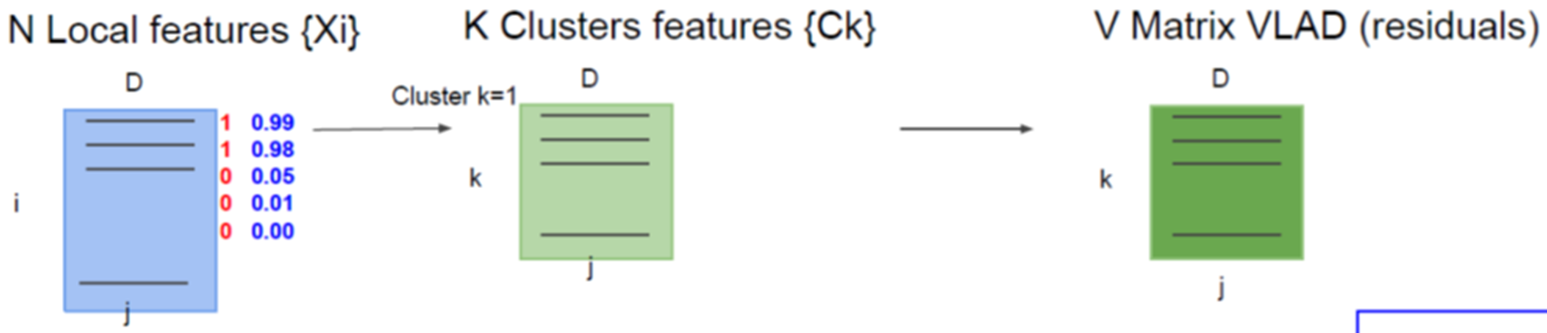

## 1. Input : Image Path(crop path)

In [8]:
#### Path
!rm -rf ./panorama_test/panorama_crop/q_crop_val/.ipynb_checkpoints/
!rm -rf ./panorama_test/panorama_crop/db_crop_val/.ipynb_checkpoints/
###### panoramo db_root
pnorm_db_root = '/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/db_crop_val/'

pnorm_db_dic = {}
for db in os.listdir(pnorm_db_root):
    
    if db != 'labels':
        db_root = pnorm_db_root + db + '/'
        db_path_list = natsort.natsorted([db_root + db_name for db_name in os.listdir(db_root) if 'jpg' in db_name or 'png' in db_name])
        pnorm_db_dic[db] = db_path_list
        
pnorm_q_root = '/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/q_crop_val/'

pnorm_q_dic = {}
for q in os.listdir(pnorm_q_root):
    
    if q != 'labels':
        q_root = pnorm_q_root + q + '/'
        q_path_list =natsort.natsorted( [q_root + q_name for q_name in os.listdir(q_root) if 'jpg' in q_name or 'png' in q_name])
        pnorm_q_dic[q] = q_path_list

### 1.1 Feature Descriptor
    1. SIFT
    2. RootSIFT

In [9]:
# SIFT
def sift_extractor(file_path):
    '''
    Description: extract \emph{sift} feature from given image
    Input: file_path - image path
    Output: des - a list of descriptors of all the keypoint from the image
    '''
    img = cv2.imread(file_path)
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create() # 1000
    _,des = sift.detectAndCompute(gray,None) 

    return des

In [10]:
# RootSIFT
# import the necessary packages

class RootSIFT:
	def __init__(self, max_kps):
		# initialize the SIFT feature extractor
		self.max_kps = max_kps
		self.extractor = cv2.SIFT_create(self.max_kps)
	def compute(self, image, kps, eps=1e-7):
		# compute SIFT descriptors
		kps, descs = self.extractor.detectAndCompute(image,kps)
		# if there are no keypoints or descriptors, return an empty tuple
		if len(kps) == 0:
			return ([], None)
		# apply the Hellinger kernel by first L1-normalizing and taking the
		# square-root(L2-noramlized)
		descs /= (descs.sum(axis=1, keepdims=True) + eps)
		descs = np.sqrt(descs)
		#descs /= (np.linalg.norm(descs, axis=1, ord=2) + eps)
		# return a tuple of the keypoints and descriptors
		return (kps, descs)

In [11]:
# RootSIFT
# input: file_path
def rootsift_extractor(file_path):
    '''
    Description: extract \emph{sift} feature from given image
    Input: file_path - image path
    Output: des - a list of descriptors of all the keypoint from the image
    '''
    img = cv2.imread(file_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    rs = RootSIFT(99999) #full
    _, des = rs.compute(gray, None) 

    return des

### - utils
    1. k-means clustering
    2. get vlad vector
    3. L2 distance(numpy)

In [12]:
def get_cluster_center(des_set, K):
    '''
    Description: cluter using a default setting
    Input: des_set - cluster data
                 K - the number of cluster center
    Output: laber  - a np array of the nearest center for each cluster data
            center - a np array of the K cluster center
    '''
    des_set = np.float32(des_set) # for kmeans 
    
##########################[CPU-SLOW OPENCV KMEANS]##########################
    # criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.01)
    
    # ret, label, center = cv2.kmeans(des_set, K, None, criteria, 3, cv2.KMEANS_RANDOM_CENTERS)
#########################################################################

##########################[GPU-FAST FAISS KMEANS]##########################
    # Setup
    kmeans = faiss.Kmeans(d=128, k=K, niter=20, verbose=True, gpu=True)
    
    # Run clustering
    kmeans.train(des_set)
    
    # Centroids after clustering
    center = kmeans.centroids
    
    # The assignment for each vector.
    _, label = kmeans.index.search(des_set, 1)  # Need to run NN search again
    
    return label, center

In [13]:
def get_des_vector(file_path_list, method='rootsift', DESDIM=128):
    '''
    Description: get descriptors of all the images 
    Input: file_path_list - all images path
           method - str, default = 'rootsift', the way of extracting feature ['sift', 'rootsift', 'orb']
    Output:       all_des - a np array of all descriptors
            image_des_len - a list of number of the keypoints for each image 
    '''
    
    # all_des = np.empty(shape=[0, DESDIM]) #float64
    all_des = np.float32([]).reshape(0,DESDIM) #float32
    image_des_len = []

    for eachFile in file_path_list:
        
        try:
            des = eval(f"{method}_extractor('{eachFile}')") # RootSIFT                
            all_des = np.concatenate([all_des, des]) #모든 이미지의 des vector를 concat 해서 출력! #np.concat : 다차원 배열의 결과
            image_des_len.append(len(des)) #각각 이미지의 len(des)을 따로 list에 모아두기.
        except:
            print(eachFile)
            print("extract feature error")
    
    # feature num count
    featCnt = all_des.shape[0] #kp 개수
    print(str(featCnt) + " features in " + " images")
    
    return all_des, image_des_len, featCnt

In [14]:
def get_codebook(all_des, K):
    '''
    Description: train the codebook from all of the descriptors
    Input: all_des - training data for the codebook
                 K - the column of the codebook
    '''
    label, center = get_cluster_center(all_des, K)
    return label, center #center -> codebook

In [15]:
def get_vlad_base(img_des_len, NNlabel, all_des, codebook, COLUMNOFCODEBOOK, DESDIM=128):
    '''
    Description: get all images vlad vector 
    '''
    cursor = 0
    vlad_base = []
    for i, eachImage in enumerate(img_des_len):
        
        descrips = all_des[cursor : cursor + eachImage]
        centriods_id = NNlabel[cursor : cursor + eachImage]
        centriods = codebook[centriods_id]
    
        vlad = np.zeros(shape=[COLUMNOFCODEBOOK, DESDIM]).astype(np.float32) # VLAD vector: K * D 차원
        for eachDes in range(eachImage):
            vlad[centriods_id[eachDes]] = vlad[centriods_id[eachDes]] + descrips[eachDes] - centriods[eachDes] #차원 별 각각 중심으로부터 거리 (lacal feature 값 - NN 중심 값)
        cursor += eachImage # cursor 이동
    
        vlad_norm = vlad.copy()
        cv2.normalize(vlad, vlad_norm, 1.0, 0.0, cv2.NORM_L2) # 0에서 1사이로 L2 Norm
        vlad_base.append(vlad_norm.reshape(COLUMNOFCODEBOOK * DESDIM, -1)) # vlad_norm : 이미지 1장 -> vlad_base : DB 모든 이미지 M장 = (K*D)*M
    
    print("get_db_vlad_feat")
    
    return vlad_base #VLAD Base Vector

In [16]:
def cal_vec_dist(vec1, vec2):
    '''
    Description: calculate the Euclidean Distance of two vectors (norm_l2)
    '''
    return np.linalg.norm(vec1 - vec2)

# query에 대해서 ON_LINE에서 진행되는 과정
def get_pic_vlad(pic, des_size, codebook, COLUMNOFCODEBOOK, DESDIM=128): # query의 vlad vector 만들기 by db의 codebook으로!
    '''
    Description: get the vlad vector of each image
    '''
    vlad = np.zeros(shape=[COLUMNOFCODEBOOK, DESDIM])
    for eachDes in range(des_size):
        des = pic[eachDes]
        min_dist = 1000000000.0
        ind = 0
        for i in range(COLUMNOFCODEBOOK):
            dist = cal_vec_dist(des, codebook[i]) # 각각 local feature가 중심으로부터 떨어진 거리
            if dist < min_dist: # 최근접 중심
                min_dist = dist
                ind = i
        vlad[ind] = vlad[ind] + des - codebook[ind] # 최근접 중심 + 떨어진 거리 : Vlad 정의
    
    vlad_norm = vlad.copy()
    cv2.normalize(vlad, vlad_norm, 1.0, 0.0, cv2.NORM_L2) #L2 Norm
    vlad_norm = vlad_norm.reshape(COLUMNOFCODEBOOK * DESDIM, -1)
    
    return vlad_norm

### 1.2 DB : get_db
    - In offline, we make db feat in advance and save it.

In [133]:
def get_db(db_path_list, save_path, featset):

    #time check - Time of learning codebook(Off_line)
    cb_t_b = time.perf_counter()

    ##get all the descriptor vectors of the data set
    print("db_feature_num")
    all_des, image_des_len, _ = get_des_vector(db_path_list, method='rootsift')

    # Time of learning codebook
    cb_t = time.perf_counter() - cb_t_b

    print(f"Time of Learning Codebook(Off_line):{cb_t}")

    #############save############
    # save all descriptors to file
    
    # save all_des
    os.makedirs(save_path, exist_ok=True)
    with open(save_path + f"test_db_{featset}_rs" + ".pkl" , 'wb') as fp: #wb, save
        pickle.dump(all_des, fp, protocol=pickle.HIGHEST_PROTOCOL)
    del all_des #save memory

    # save image_des_len(list)
    os.makedirs(save_path, exist_ok=True)
    with open(save_path + f"test_db_vlad_{featset}_len" + ".pkl" , 'wb') as fp: #wb, save
        pickle.dump(image_des_len, fp, protocol=pickle.HIGHEST_PROTOCOL)
    del image_des_len #save memory
    
    # alarm
    print(f"get_db_{featset}")
###exec####

# DESDIM = 128 # SIFT - 128 / ORB - 32

save_path = "/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/checkpoint/feat_set/"
#pnorm_db_dic[db] = db_path_list

start = time.perf_counter()

for i, db in enumerate(pnorm_db_dic.keys()):
    
    #process
    print(f"{i}/{len(pnorm_db_dic)}")
    
    #exec
    get_db(db_path_list=pnorm_db_dic[db], save_path=save_path, featset=db)

get_db_time = time.perf_counter() - start
print(f"get_db_time : {get_db_time}", f"get_db_per_query : {get_db_time/len(pnorm_db_dic)}")

#time
# get_db_time : 2.7983252509729937 get_db_per_query : 0.028848713927556637
# get_db_time : 3.2516509029082954 get_db_per_query : 0.03352217425678655

0/97
db_feature_num
2419 features in  images
Time of Learning Codebook(Off_line):0.08417913306038827
get_db_870
1/97
db_feature_num
414 features in  images
Time of Learning Codebook(Off_line):0.016131491982378066
get_db_150
2/97
db_feature_num
468 features in  images
Time of Learning Codebook(Off_line):0.015606119064614177
get_db_930
3/97
db_feature_num
168 features in  images
Time of Learning Codebook(Off_line):0.009488218114711344
get_db_580
4/97
db_feature_num
912 features in  images
Time of Learning Codebook(Off_line):0.02896014496218413
get_db_370
5/97
db_feature_num
1006 features in  images
Time of Learning Codebook(Off_line):0.029236466041766107
get_db_730
6/97
db_feature_num
124 features in  images
Time of Learning Codebook(Off_line):0.0065057630417868495
get_db_160
7/97
db_feature_num
334 features in  images
Time of Learning Codebook(Off_line):0.025386565015651286
get_db_290
8/97
db_feature_num
813 features in  images
Time of Learning Codebook(Off_line):0.03371242305729538
get

### 1.3 Retrieval : ret_vlad
    - SIFT Descriptor & VLAD feature aggregation
    - faiss, Cosine Similarity Matching

In [137]:
# panorama 

# def ret_kp(q_path_list, db_path_list, panorama_id, dic_save_path, txt_save_path, matcher='bf', metric="l2", method='rootsift', \
#            val = "union", cross_check=True, img_format='jpg'):

def ret_vlad(q_path_list, db_path_list, load_path, panorama_id, dic_save_path, txt_save_path,method=='rootsift',\
             metric="cs", device='cpu'): # for iter
    
    '''
    method : str, how to extract feature from image, ['rootsift', 'sift']
    metric : str, how to compare with vectors, ["l2", "cs"], l2 is Euclidean Distance, cs is Cosine Similarity
    device : str, if 'cpu', faiss search with cpu else, 'gpu' or 'cuda', anything.
    '''
    
    # load DB all descriptors
    fp = load_path + f"test_db_{panorama_id}_rs" + ".pkl" 
    all_des = pickle.load(open(fp, "rb"))

    # load image_des_len(list)
    with open(load_path + f'test_db_vlad_{panorama_id}_len' + '.pkl', 'rb') as fp: #len은 동일
        image_des_len = pickle.load(fp)

    #time check - Time of Retrieval(On_line)
    ret_t_b = time.perf_counter()

    ##get all the descriptor vectors of the query set
    print("q_feature_num")
    ret_des, ret_des_len, featCnt = get_des_vector(q_path_list, method)
    
    #faiss clustering auto setting
    COLUMNOFCODEBOOK = int(featCnt / 39)

    ##trainning the codebook
    NNlabel, codebook = get_codebook(all_des, COLUMNOFCODEBOOK) #DB 사이즈에 따라 CD 크기가 바뀌므로, 매번 뽑아줘야 한다.
    
    #get all vlad vectors of the db set
    vlad_base = get_vlad_base(image_des_len, NNlabel, all_des, codebook, COLUMNOFCODEBOOK)
    del all_des #save memory
    
    db_num = len(image_des_len)
    del image_des_len #save memory

    ##get all the vlad vectors of retrival set without pca dimensionality reduction
    cursor_ret = 0
    ret_vlad_list = []
    for i, eachretpic in enumerate(range(len(ret_des_len))): #각각 이미지 des 길이들 만큼만 pick! -> 이미지 1장 1장에 대해 retrieval 해야 하므로!
        print(f"{i}/{len(ret_des_len)}")
        pic = ret_des[cursor_ret: cursor_ret + ret_des_len[eachretpic]]
        ret_vlad = get_pic_vlad(pic, ret_des_len[eachretpic], codebook, COLUMNOFCODEBOOK) # COLUMNOFCODEBOOK #CD
        cursor_ret += ret_des_len[eachretpic] # next cursor
        ret_vlad_list.append(ret_vlad)
    del ret_des, ret_des_len #save memory
    
# ==
    ### for faiss ###
    ### kernel died because of doulbing memory by copying it
    vlad_base = np.array(vlad_base).reshape(len(vlad_base), -1) #(개수, 차원) ex) K=5500 (3369, 704000)
    vlad_base = vlad_base.astype(np.float32)
    
    ret_vlad_set = np.array(ret_vlad_list).reshape(len(ret_vlad_list), -1) #(개수, 차원) ex) K=5500, (100, 704,000)
    ret_vlad_set = ret_vlad_set.astype(np.float32)
    
    print("faiss_search")
    start_rd = time.perf_counter()
    
    ## faiss similarity search ##
    faiss.normalize_L2(vlad_base) # 자신의 절댓값 크기(sqrt(self**2))로 나눠준다.
    faiss.normalize_L2(ret_vlad_set)
    
    dim = COLUMNOFCODEBOOK * DESDIM # vlad_dim: K*D
    if metric == "l2":  # Norm L2 Dist
        cpu_index = faiss.IndexFlatL2(dim)
        
    else : # cosine similarity
        cpu_index = faiss.IndexFlatIP(dim)
        
    if device == 'cpu':
        cpu_index.add(vlad_base)
        del vlad_base #save memory

        start = time.perf_counter()
        D, I = cpu_index.search(ret_vlad_set, cpu_index.ntotal) # 전체 쿼리(병렬) 몇 등까지 볼거야? 전체 다!
        print(' faiss search time: ', time.perf_counter()-start)
        
    else: #'cuda', 'gpu'
        #Clone from CPU to GPU
        co = faiss.GpuMultipleClonerOptions()
        co.shard = True
        co.useFloat16 = True
        index = faiss.index_cpu_to_all_gpus(cpu_index, co=co) # build the index
        index.add(vlad_base)
        del vlad_base #save memory
        
        start = time.perf_counter()
        D, I = index.search(ret_vlad_set, index.ntotal) # 전체 쿼리(병렬) 몇 등까지 볼거야? 전체 다!
        print(' faiss search time: ', time.perf_counter()-start)
        
    q_num = ret_vlad_set.shape[0]
    del ret_vlad_set #save memory
    
    #out result dic
    result_dic = {}
    
    for q_idx in range(q_num): # query index
        eval_list = []
        for db_idx in range(db_num): # db index
            eval_list.append((I[q_idx,db_idx], D[q_idx,db_idx]))
        result_dic[q_idx] = eval_list
    
    # get_result_time
    print("get_result_dic", time.perf_counter()-start_rd)

    #time check - Time of Retrieval(On_line)
    ret_t = time.perf_counter() - ret_t_b
    print(f"Time of Retrieval(On_line):{ret_t}")
    
   #save result dict
    os.makedirs(dic_save_path + f"/{metric}/", exist_ok=True)
    with open(dic_save_path + f"/{metric}/dic_{panorama_id}_sift" + ".p", 'wb') as fp: #rs : RootSIFT
        pickle.dump(result_dic, fp, protocol=pickle.HIGHEST_PROTOCOL)

    # save top1 pair .txt
    os.makedirs(txt_save_path + f"/{metric}/", exist_ok=True)
    out_file = txt_save_path + f"/{metric}/pair_{panorama_id}_sift" + ".txt"
    f_out = open(out_file, 'w')

    for q_idx in list(result_dic.keys()):
        #### L2 Distance/ Cos_Sim ####
        if metric == "l2":  # Norm L2 Dist
            rank_list = sorted(result_dic[q_idx], key = lambda x: x[1]) # Norm l2 dist
        else : # cosine similarity
            rank_list = sorted(result_dic[q_idx], key = lambda x: -x[1]) #cos sim
        ##############################
        for (db_idx, score)  in rank_list:
            query_name = Path(q_path_list[q_idx]).stem
            db_name = Path(db_path_list[db_idx]).stem
            
            f_out.write(query_name + '.jpg,' + db_name + '.jpg,' + str(score) + '\n')
            f_out.flush()
    f_out.close()
     
### exec ###

load_path = "/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/checkpoint/feat_set/"
dic_save_path = "/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/result/result_dic/vlad/"
txt_save_path = "/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/result/pair_txt/vlad/"

start = time.perf_counter()
for i, q in enumerate(pnorm_q_dic.keys()):

    #process
    print(f"{i}/{len(pnorm_q_dic)}")
    
    # try: # query ID == db ID
        #exec
    ret_vlad(q_path_list=pnorm_q_dic[q], db_path_list=pnorm_db_dic[q], panorama_id=q, \

             load_path=load_path, dic_save_path=dic_save_path, txt_save_path=txt_save_path, metric="cs")

    # except: # if query ID not in db ID
    #     print("ID error")
    #     print(f"query ID : {q}")
        
print("total_ret_time", time.perf_counter()-start)
#time
# total_ret_time 40.83246005396359
# ret_time_per_q 0.4209531964326143

0/97
q_feature_num
2312 features in  images

Clustering 2419 points in 128D to 59 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.03 s, search 0.01 s): objective=530.272 imbalance=1.085 nsplit=0       
0/23
1/23
2/23
3/23
4/23
5/23
6/23
7/23
8/23
9/23
10/23
11/23
12/23
13/23
14/23
15/23
16/23
17/23
18/23
19/23
20/23
21/23
22/23
faiss_search
 faiss search time:  0.0004960519727319479
get_result_dic 0.0012823579600080848
Time of Retrieval(On_line):0.961330943973735
1/97
q_feature_num
273 features in  images

Clustering 414 points in 128D to 7 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=118.408 imbalance=1.065 nsplit=0       
0/14
1/14
2/14
3/14
4/14
5/14
6/14
7/14
8/14
9/14
10/14
11/14
12/14
13/14
faiss_search
 faiss search time:  3.552797716110945e-05
get_result_dic 0.012248728075064719
Time of Retrieval(On_line):0.33105905004777014
2/97
q_feature_num
501 features in  images

Clusteri

WARNING clustering 168 points to 9 centroids: please provide at least 351 training points



Clustering 168 points in 128D to 9 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=39.5143 imbalance=1.208 nsplit=0       
0/4
1/4
2/4
3/4
faiss_search
 faiss search time:  2.7860049158334732e-05
get_result_dic 0.00033045304007828236
Time of Retrieval(On_line):0.31396897905506194
4/97
q_feature_num
452 features in  images

Clustering 912 points in 128D to 11 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.00 s): objective=246.809 imbalance=1.040 nsplit=0       
0/6
1/6
2/6
3/6
4/6
5/6
faiss_search
 faiss search time:  3.6205979995429516e-05
get_result_dic 0.0003345540026202798
Time of Retrieval(On_line):0.3213462370913476
5/97
q_feature_num
1137 features in  images


WARNING clustering 1006 points to 29 centroids: please provide at least 1131 training points



Clustering 1006 points in 128D to 29 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.00 s): objective=224.318 imbalance=1.153 nsplit=0       
0/13
1/13
2/13
3/13
4/13
5/13
6/13
7/13
8/13
9/13
10/13
11/13
12/13
faiss_search
 faiss search time:  0.00011416897177696228
get_result_dic 0.012340727960690856
Time of Retrieval(On_line):0.473720868001692
6/97
q_feature_num
161 features in  images


WARNING clustering 124 points to 4 centroids: please provide at least 156 training points



Clustering 124 points in 128D to 4 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=32.9287 imbalance=1.228 nsplit=0       
0/4
1/4
2/4
3/4
faiss_search
 faiss search time:  2.2885971702635288e-05
get_result_dic 0.010838287067599595
Time of Retrieval(On_line):0.3215008080005646
7/97
q_feature_num
544 features in  images


WARNING clustering 334 points to 13 centroids: please provide at least 507 training points



Clustering 334 points in 128D to 13 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.00 s): objective=87.8796 imbalance=1.180 nsplit=0       
0/22
1/22
2/22
3/22
4/22
5/22
6/22
7/22
8/22
9/22
10/22
11/22
12/22
13/22
14/22
15/22
16/22
17/22
18/22
19/22
20/22
21/22
faiss_search
 faiss search time:  0.0001113259932026267
get_result_dic 0.000549574033357203
Time of Retrieval(On_line):0.3457445310195908
8/97
q_feature_num
1036 features in  images


WARNING clustering 813 points to 26 centroids: please provide at least 1014 training points



Clustering 813 points in 128D to 26 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=181.873 imbalance=1.108 nsplit=0       
0/20
1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
faiss_search
 faiss search time:  0.0001489110291004181
get_result_dic 0.0006017020205035806
Time of Retrieval(On_line):0.4559953500283882
9/97
q_feature_num
507 features in  images

Clustering 596 points in 128D to 13 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.00 s): objective=152.331 imbalance=1.063 nsplit=0       
0/16
1/16
2/16
3/16
4/16
5/16
6/16
7/16
8/16
9/16
10/16
11/16
12/16
13/16
14/16
15/16
faiss_search
 faiss search time:  6.804394070059061e-05
get_result_dic 0.00045115500688552856
Time of Retrieval(On_line):0.3468204439850524
10/97
q_feature_num
986 features in  images


WARNING clustering 931 points to 25 centroids: please provide at least 975 training points



Clustering 931 points in 128D to 25 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.00 s): objective=227.894 imbalance=1.153 nsplit=0       
0/15
1/15
2/15
3/15
4/15
5/15
6/15
7/15
8/15
9/15
10/15
11/15
12/15
13/15
14/15
faiss_search
 faiss search time:  0.0001503040548413992
get_result_dic 0.000584615976549685
Time of Retrieval(On_line):0.4308535830350593
11/97
q_feature_num
1041 features in  images

Clustering 1016 points in 128D to 26 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=232.039 imbalance=1.095 nsplit=0       
0/9
1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9
faiss_search
 faiss search time:  8.135195821523666e-05
get_result_dic 0.00042047700844705105
Time of Retrieval(On_line):0.4499234900576994
12/97
q_feature_num
94 features in  images

Clustering 25 points in 128D to 2 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s


WARNING clustering 25 points to 2 centroids: please provide at least 78 training points


get_db_vlad_feat0.02 s, search 0.00 s): objective=6.66048 imbalance=1.014 nsplit=0       
0/5
1/5
2/5
3/5
4/5
faiss_search
 faiss search time:  1.583993434906006e-05
get_result_dic 0.01186741900164634
Time of Retrieval(On_line):0.3088983059860766
13/97
q_feature_num
377 features in  images


WARNING clustering 73 points to 9 centroids: please provide at least 351 training points



Clustering 73 points in 128D to 9 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.00 s): objective=16.2091 imbalance=1.211 nsplit=0       
0/9
1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9
faiss_search
 faiss search time:  2.5073997676372528e-05
get_result_dic 0.0003141749184578657
Time of Retrieval(On_line):0.31819331308361143
14/97
q_feature_num
/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/q_crop_val/410/0_100_False.jpg
extract feature error
1216 features in  images


WARNING clustering 1130 points to 31 centroids: please provide at least 1209 training points



Clustering 1130 points in 128D to 31 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.01 s): objective=264.26 imbalance=1.133 nsplit=0        
0/23
1/23
2/23
3/23
4/23
5/23
6/23
7/23
8/23
9/23
10/23
11/23
12/23
13/23
14/23
15/23
16/23
17/23
18/23
19/23
20/23
21/23
22/23
faiss_search
 faiss search time:  0.0002368789864704013
get_result_dic 0.0007831279654055834
Time of Retrieval(On_line):0.4950923779979348
15/97
q_feature_num
377 features in  images

Clustering 562 points in 128D to 9 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=150.455 imbalance=1.105 nsplit=0       
0/4
1/4
2/4
3/4
faiss_search
 faiss search time:  2.9462971724569798e-05
get_result_dic 0.00034042203333228827
Time of Retrieval(On_line):0.323167018010281
16/97
q_feature_num
658 features in  images

Clustering 1310 points in 128D to 16 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_d

WARNING clustering 754 points to 24 centroids: please provide at least 936 training points



Clustering 754 points in 128D to 24 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=187.244 imbalance=1.098 nsplit=0       
0/19
1/19
2/19
3/19
4/19
5/19
6/19
7/19
8/19
9/19
10/19
11/19
12/19
13/19
14/19
15/19
16/19
17/19
18/19
faiss_search
 faiss search time:  0.0001784859923645854
get_result_dic 0.000629273010417819
Time of Retrieval(On_line):0.4288603550521657
19/97
q_feature_num
695 features in  images

Clustering 728 points in 128D to 17 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=181.27 imbalance=1.069 nsplit=0        
0/12
1/12
2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
faiss_search
 faiss search time:  7.9092918895185e-05
get_result_dic 0.00044361501932144165
Time of Retrieval(On_line):0.3743300309870392
20/97
q_feature_num
504 features in  images

Clustering 396 points in 128D to 12 clusters, redo 1 times, 20 iterations
  Preprocessi

WARNING clustering 396 points to 12 centroids: please provide at least 468 training points


get_db_vlad_feat
0/17
1/17
2/17
3/17
4/17
5/17
6/17
7/17
8/17
9/17
10/17
11/17
12/17
13/17
14/17
15/17
16/17
faiss_search
 faiss search time:  8.212495595216751e-05
get_result_dic 0.00047937105409801006
Time of Retrieval(On_line):0.3451020420761779
21/97
q_feature_num
/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/q_crop_val/480/5_4_False.jpg
extract feature error
1468 features in  images


WARNING clustering 1116 points to 37 centroids: please provide at least 1443 training points



Clustering 1116 points in 128D to 37 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.01 s): objective=255.22 imbalance=1.132 nsplit=0        
0/20
1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
faiss_search
 faiss search time:  0.00016726600006222725
get_result_dic 0.0032665079925209284
Time of Retrieval(On_line):0.5706550230970606
22/97
q_feature_num
1079 features in  images


WARNING clustering 920 points to 27 centroids: please provide at least 1053 training points



Clustering 920 points in 128D to 27 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=220.12 imbalance=1.051 nsplit=0        
0/14
1/14
2/14
3/14
4/14
5/14
6/14
7/14
8/14
9/14
10/14
11/14
12/14
13/14
faiss_search
 faiss search time:  0.00010752503294497728
get_result_dic 0.00047109508886933327
Time of Retrieval(On_line):0.4525104670319706
23/97
q_feature_num
449 features in  images


WARNING clustering 428 points to 11 centroids: please provide at least 429 training points



Clustering 428 points in 128D to 11 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=113.039 imbalance=1.201 nsplit=0       
0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
faiss_search
 faiss search time:  3.977399319410324e-05
get_result_dic 0.00036356900818645954
Time of Retrieval(On_line):0.34088128502480686
24/97
q_feature_num
597 features in  images

Clustering 725 points in 128D to 15 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=183.182 imbalance=1.123 nsplit=0       
0/14
1/14
2/14
3/14
4/14
5/14
6/14
7/14
8/14
9/14
10/14
11/14
12/14
13/14
faiss_search
 faiss search time:  6.219395436346531e-05
get_result_dic 0.005921007948927581
Time of Retrieval(On_line):0.368499975069426
25/97
q_feature_num
/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/q_crop_val/210/1_100_False.jpg
extract feature error
590 features in  images


WARNING clustering 495 points to 15 centroids: please provide at least 585 training points



Clustering 495 points in 128D to 15 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=120.377 imbalance=1.263 nsplit=0       
0/19
1/19
2/19
3/19
4/19
5/19
6/19
7/19
8/19
9/19
10/19
11/19
12/19
13/19
14/19
15/19
16/19
17/19
18/19
faiss_search
 faiss search time:  0.0001308040227741003
get_result_dic 0.0005909050814807415
Time of Retrieval(On_line):0.36285545595455915
26/97
q_feature_num
631 features in  images


WARNING clustering 502 points to 16 centroids: please provide at least 624 training points



Clustering 502 points in 128D to 16 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=124.96 imbalance=1.186 nsplit=0        
0/5
1/5
2/5
3/5
4/5
faiss_search
 faiss search time:  3.210199065506458e-05
get_result_dic 0.00031259097158908844
Time of Retrieval(On_line):0.3537717580329627
27/97
q_feature_num
735 features in  images

Clustering 769 points in 128D to 18 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=184.149 imbalance=1.084 nsplit=0       
0/9
1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9
faiss_search
 faiss search time:  7.203698623925447e-05
get_result_dic 0.0004190119216218591
Time of Retrieval(On_line):0.3706878930097446
28/97
q_feature_num
422 features in  images

Clustering 953 points in 128D to 10 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=260.142 imbalance=1.094 nsplit=0       
0/7


WARNING clustering 372 points to 13 centroids: please provide at least 507 training points



Clustering 372 points in 128D to 13 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.00 s): objective=94.8157 imbalance=1.103 nsplit=0       
0/13
1/13
2/13
3/13
4/13
5/13
6/13
7/13
8/13
9/13
10/13
11/13
12/13
faiss_search
 faiss search time:  4.043104127049446e-05
get_result_dic 0.0003588879480957985
Time of Retrieval(On_line):0.34185474005062133
31/97
q_feature_num
340 features in  images

Clustering 367 points in 128D to 8 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.03 s, search 0.00 s): objective=98.4011 imbalance=1.047 nsplit=0       
0/9
1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9
faiss_search
 faiss search time:  3.345799632370472e-05
get_result_dic 0.00034563394729048014
Time of Retrieval(On_line):0.35833366692531854
32/97
q_feature_num
670 features in  images


WARNING clustering 580 points to 17 centroids: please provide at least 663 training points



Clustering 580 points in 128D to 17 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=140.329 imbalance=1.070 nsplit=0       
0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
faiss_search
 faiss search time:  5.3666066378355026e-05
get_result_dic 0.00038000696804374456
Time of Retrieval(On_line):0.42472867702599615
33/97
q_feature_num
/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/q_crop_val/450/1_100_False.jpg
extract feature error
802 features in  images

Clustering 826 points in 128D to 20 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.00 s): objective=210.95 imbalance=1.099 nsplit=0        
0/17
1/17
2/17
3/17
4/17
5/17
6/17
7/17
8/17
9/17
10/17
11/17
12/17
13/17
14/17
15/17
16/17
faiss_search
 faiss search time:  0.00015245110262185335
get_result_dic 0.0005844109691679478
Time of Retrieval(On_line):0.46048754500225186
34/97
q_feature_num
127 

WARNING clustering 409 points to 20 centroids: please provide at least 780 training points



Clustering 409 points in 128D to 20 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.03 s, search 0.00 s): objective=103.053 imbalance=1.233 nsplit=0       
0/9
1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9
faiss_search
 faiss search time:  5.031307227909565e-05
get_result_dic 0.012473457958549261
Time of Retrieval(On_line):0.40826212300453335
36/97
q_feature_num
672 features in  images

Clustering 953 points in 128D to 17 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.04 s, search 0.00 s): objective=226.931 imbalance=1.082 nsplit=0       
0/14
1/14
2/14
3/14
4/14
5/14
6/14
7/14
8/14
9/14
10/14
11/14
12/14
13/14
faiss_search
 faiss search time:  7.828907109797001e-05
get_result_dic 0.00044353294651955366
Time of Retrieval(On_line):0.43529264291282743
37/97
q_feature_num
905 features in  images

Clustering 903 points in 128D to 23 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s):

WARNING clustering 810 points to 21 centroids: please provide at least 819 training points



Clustering 810 points in 128D to 21 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=200.744 imbalance=1.150 nsplit=0       
0/24
1/24
2/24
3/24
4/24
5/24
6/24
7/24
8/24
9/24
10/24
11/24
12/24
13/24
14/24
15/24
16/24
17/24
18/24
19/24
20/24
21/24
22/24
23/24
faiss_search
 faiss search time:  0.00016555993352085352
get_result_dic 0.0007108669960871339
Time of Retrieval(On_line):0.4073851649882272
39/97
q_feature_num
639 features in  images


WARNING clustering 416 points to 16 centroids: please provide at least 624 training points



Clustering 416 points in 128D to 16 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=99.0579 imbalance=1.126 nsplit=0       
0/22
1/22
2/22
3/22
4/22
5/22
6/22
7/22
8/22
9/22
10/22
11/22
12/22
13/22
14/22
15/22
16/22
17/22
18/22
19/22
20/22
21/22
faiss_search
 faiss search time:  0.00010837602894753218
get_result_dic 0.00610525393858552
Time of Retrieval(On_line):0.37913144298363477
40/97
q_feature_num
/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/q_crop_val/30/2_100_False.jpg
extract feature error
241 features in  images


WARNING clustering 187 points to 6 centroids: please provide at least 234 training points



Clustering 187 points in 128D to 6 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.00 s): objective=52.5495 imbalance=1.161 nsplit=0       
0/5
1/5
2/5
3/5
4/5
faiss_search
 faiss search time:  1.801503822207451e-05
get_result_dic 0.00031205289997160435
Time of Retrieval(On_line):0.3043191710021347
41/97
q_feature_num
1538 features in  images

Clustering 1521 points in 128D to 39 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.00 s): objective=353.419 imbalance=1.102 nsplit=0       
0/27
1/27
2/27
3/27
4/27
5/27
6/27
7/27
8/27
9/27
10/27
11/27
12/27
13/27
14/27
15/27
16/27
17/27
18/27
19/27
20/27
21/27
22/27
23/27
24/27
25/27
26/27
faiss_search
 faiss search time:  0.0003816429525613785
get_result_dic 0.0011304650688543916
Time of Retrieval(On_line):0.5889228839660063
42/97
q_feature_num
1770 features in  images

Clustering 2145 points in 128D to 45 clusters, redo 1 times, 20 iterations
 

WARNING clustering 279 points to 19 centroids: please provide at least 741 training points



Clustering 279 points in 128D to 19 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=54.688 imbalance=1.306 nsplit=0       
0/1
faiss_search
 faiss search time:  1.9464059732854366e-05
get_result_dic 0.00030765996780246496
Time of Retrieval(On_line):0.37319499999284744
44/97
q_feature_num
1545 features in  images

Clustering 2042 points in 128D to 39 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.01 s): objective=475.64 imbalance=1.125 nsplit=0        
0/21
1/21
2/21
3/21
4/21
5/21
6/21
7/21
8/21
9/21
10/21
11/21
12/21
13/21
14/21
15/21
16/21
17/21
18/21
19/21
20/21
faiss_search
 faiss search time:  0.0003142469795420766
get_result_dic 0.0009180450579151511
Time of Retrieval(On_line):0.606209788005799
45/97
q_feature_num
1875 features in  images


WARNING clustering 1667 points to 48 centroids: please provide at least 1872 training points



Clustering 1667 points in 128D to 48 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.01 s): objective=359.473 imbalance=1.183 nsplit=0       
0/18
1/18
2/18
3/18
4/18
5/18
6/18
7/18
8/18
9/18
10/18
11/18
12/18
13/18
14/18
15/18
16/18
17/18
faiss_search
 faiss search time:  0.0003593410365283489
get_result_dic 0.0008356109028682113
Time of Retrieval(On_line):0.7091197690460831
46/97
q_feature_num
926 features in  images

Clustering 1962 points in 128D to 23 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.01 s): objective=493.811 imbalance=1.049 nsplit=0       
0/19
1/19
2/19
3/19
4/19
5/19
6/19
7/19
8/19
9/19
10/19
11/19
12/19
13/19
14/19
15/19
16/19
17/19
18/19
faiss_search
 faiss search time:  0.0002417959040030837
get_result_dic 0.0008426880231127143
Time of Retrieval(On_line):0.429802353028208
47/97
q_feature_num
1224 features in  images

Clustering 1251 points in 128D to 31 clusters, 

WARNING clustering 636 points to 27 centroids: please provide at least 1053 training points



Clustering 636 points in 128D to 27 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=147.186 imbalance=1.160 nsplit=0       
0/31
1/31
2/31
3/31
4/31
5/31
6/31
7/31
8/31
9/31
10/31
11/31
12/31
13/31
14/31
15/31
16/31
17/31
18/31
19/31
20/31
21/31
22/31
23/31
24/31
25/31
26/31
27/31
28/31
29/31
30/31
faiss_search
 faiss search time:  0.0002164921024814248
get_result_dic 0.0008093870710581541
Time of Retrieval(On_line):0.4602306740125641
49/97
q_feature_num
/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/q_crop_val/910/3_100_False.jpg
extract feature error
1116 features in  images

Clustering 1575 points in 128D to 28 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.03 s, search 0.01 s): objective=383.425 imbalance=1.135 nsplit=0       
0/22
1/22
2/22
3/22
4/22
5/22
6/22
7/22
8/22
9/22
10/22
11/22
12/22
13/22
14/22
15/22
16/22
17/22
18/22
19/22
20/22
21/22
faiss_sear

WARNING clustering 507 points to 21 centroids: please provide at least 819 training points


get_db_vlad_feat
0/19
1/19
2/19
3/19
4/19
5/19
6/19
7/19
8/19
9/19
10/19
11/19
12/19
13/19
14/19
15/19
16/19
17/19
18/19
faiss_search
 faiss search time:  0.00014948798343539238
get_result_dic 0.0005762840155512094
Time of Retrieval(On_line):0.4012507429579273
51/97
q_feature_num
151 features in  images

Clustering 127 points in 128D to 3 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=36.9522 imbalance=1.301 nsplit=0       
0/5
1/5
2/5
3/5
4/5
faiss_search
 faiss search time:  2.7774018235504627e-05
get_result_dic 0.010483975056558847
Time of Retrieval(On_line):0.3092834330163896
52/97
q_feature_num
558 features in  images


WARNING clustering 357 points to 14 centroids: please provide at least 546 training points



Clustering 357 points in 128D to 14 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.00 s): objective=87.4668 imbalance=1.177 nsplit=0       
0/14
1/14
2/14
3/14
4/14
5/14
6/14
7/14
8/14
9/14
10/14
11/14
12/14
13/14
faiss_search
 faiss search time:  6.280303932726383e-05
get_result_dic 0.0018480009166523814
Time of Retrieval(On_line):0.3421549319755286
53/97
q_feature_num
1327 features in  images

Clustering 1121 points in 128D to 34 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s


WARNING clustering 1121 points to 34 centroids: please provide at least 1326 training points


get_db_vlad_feat
0/30
1/30
2/30
3/30
4/30
5/30
6/30
7/30
8/30
9/30
10/30
11/30
12/30
13/30
14/30
15/30
16/30
17/30
18/30
19/30
20/30
21/30
22/30
23/30
24/30
25/30
26/30
27/30
28/30
29/30
faiss_search
 faiss search time:  0.0003094370476901531
get_result_dic 0.0009832089999690652
Time of Retrieval(On_line):0.5373005230212584
54/97
q_feature_num
331 features in  images

Clustering 308 points in 128D to 8 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s


WARNING clustering 308 points to 8 centroids: please provide at least 312 training points


get_db_vlad_feat
0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
faiss_search
 faiss search time:  3.364903386682272e-05
get_result_dic 0.003040045965462923
Time of Retrieval(On_line):0.31167711794842035
55/97
q_feature_num
1289 features in  images


WARNING clustering 783 points to 33 centroids: please provide at least 1287 training points



Clustering 783 points in 128D to 33 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=169.639 imbalance=1.230 nsplit=0       
0/15
1/15
2/15
3/15
4/15
5/15
6/15
7/15
8/15
9/15
10/15
11/15
12/15
13/15
14/15
faiss_search
 faiss search time:  0.00014554301742464304
get_result_dic 0.0005420689703896642
Time of Retrieval(On_line):0.521100850077346
56/97
q_feature_num
417 features in  images


WARNING clustering 352 points to 10 centroids: please provide at least 390 training points



Clustering 352 points in 128D to 10 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=87.7491 imbalance=1.140 nsplit=0       
0/9
1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9
faiss_search
 faiss search time:  3.814592491835356e-05
get_result_dic 0.0003645590040832758
Time of Retrieval(On_line):0.34615537291392684
57/97
q_feature_num
803 features in  images

Clustering 1408 points in 128D to 20 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.01 s): objective=343.947 imbalance=1.093 nsplit=0       
0/31
1/31
2/31
3/31
4/31
5/31
6/31
7/31
8/31
9/31
10/31
11/31
12/31
13/31
14/31
15/31
16/31
17/31
18/31
19/31
20/31
21/31
22/31
23/31
24/31
25/31
26/31
27/31
28/31
29/31
30/31
faiss_search
 faiss search time:  0.00025007501244544983
get_result_dic 0.0010048469994217157
Time of Retrieval(On_line):0.4828488118946552
58/97
q_feature_num
931 features in  images


WARNING clustering 842 points to 23 centroids: please provide at least 897 training points



Clustering 842 points in 128D to 23 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.03 s, search 0.00 s): objective=196.335 imbalance=1.131 nsplit=0       
0/16
1/16
2/16
3/16
4/16
5/16
6/16
7/16
8/16
9/16
10/16
11/16
12/16
13/16
14/16
15/16
faiss_search
 faiss search time:  0.00012017495464533567
get_result_dic 0.0005103669827803969
Time of Retrieval(On_line):0.5217164719942957
59/97
q_feature_num
902 features in  images

Clustering 1064 points in 128D to 23 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=255.924 imbalance=1.141 nsplit=0       
0/11
1/11
2/11
3/11
4/11
5/11
6/11
7/11
8/11
9/11
10/11
faiss_search
 faiss search time:  7.344293408095837e-05
get_result_dic 0.00041000195778906345
Time of Retrieval(On_line):0.47534285800065845
60/97
q_feature_num
213 features in  images


WARNING clustering 64 points to 5 centroids: please provide at least 195 training points



Clustering 64 points in 128D to 5 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.00 s): objective=18.2009 imbalance=1.685 nsplit=0       
0/5
1/5
2/5
3/5
4/5
faiss_search
 faiss search time:  1.825799699872732e-05
get_result_dic 0.0034647929714992642
Time of Retrieval(On_line):0.31595269101671875
61/97
q_feature_num
878 features in  images


WARNING clustering 718 points to 22 centroids: please provide at least 858 training points



Clustering 718 points in 128D to 22 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.00 s): objective=171.075 imbalance=1.186 nsplit=0       
0/13
1/13
2/13
3/13
4/13
5/13
6/13
7/13
8/13
9/13
10/13
11/13
12/13
faiss_search
 faiss search time:  0.0001027469988912344
get_result_dic 0.00270230695605278
Time of Retrieval(On_line):0.3987354510463774
62/97
q_feature_num
619 features in  images


WARNING clustering 514 points to 15 centroids: please provide at least 585 training points



Clustering 514 points in 128D to 15 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=127.822 imbalance=1.191 nsplit=0       
0/23
1/23
2/23
3/23
4/23
5/23
6/23
7/23
8/23
9/23
10/23
11/23
12/23
13/23
14/23
15/23
16/23
17/23
18/23
19/23
20/23
21/23
22/23
faiss_search
 faiss search time:  9.914301335811615e-05
get_result_dic 0.009419017005711794
Time of Retrieval(On_line):0.38463117997162044
63/97
q_feature_num
561 features in  images


WARNING clustering 329 points to 14 centroids: please provide at least 546 training points



Clustering 329 points in 128D to 14 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=82.8085 imbalance=1.200 nsplit=0       
0/12
1/12
2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
faiss_search
 faiss search time:  4.6618981286883354e-05
get_result_dic 0.0003813049988821149
Time of Retrieval(On_line):0.3441563049564138
64/97
q_feature_num
844 features in  images


WARNING clustering 674 points to 21 centroids: please provide at least 819 training points



Clustering 674 points in 128D to 21 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=159.624 imbalance=1.231 nsplit=0       
0/6
1/6
2/6
3/6
4/6
5/6
faiss_search
 faiss search time:  3.127497620880604e-05
get_result_dic 0.0003267499851062894
Time of Retrieval(On_line):0.40461075806524605
65/97
q_feature_num
146 features in  images

Clustering 282 points in 128D to 3 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=89.8148 imbalance=1.069 nsplit=0       
0/6
1/6
2/6
3/6
4/6
5/6
faiss_search
 faiss search time:  1.8077902495861053e-05
get_result_dic 0.009108097990974784
Time of Retrieval(On_line):0.31019076704978943
66/97
q_feature_num
2795 features in  images

Clustering 2509 points in 128D to 71 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s


WARNING clustering 2509 points to 71 centroids: please provide at least 2769 training points


get_db_vlad_feat
0/23
1/23
2/23
3/23
4/23
5/23
6/23
7/23
8/23
9/23
10/23
11/23
12/23
13/23
14/23
15/23
16/23
17/23
18/23
19/23
20/23
21/23
22/23
faiss_search
 faiss search time:  0.00033059006091207266
get_result_dic 0.0008821290684863925
Time of Retrieval(On_line):1.1744363430188969
67/97
q_feature_num
87 features in  images

Sampling a subset of 512 / 657 for training
Clustering 512 points in 128D to 2 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=154.522 imbalance=1.001 nsplit=0       
0/3
1/3
2/3
faiss_search
 faiss search time:  1.7606071196496487e-05
get_result_dic 0.0006326069124042988
Time of Retrieval(On_line):0.3027765490114689
68/97
q_feature_num
231 features in  images


WARNING clustering 147 points to 5 centroids: please provide at least 195 training points



Clustering 147 points in 128D to 5 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=41.5434 imbalance=1.217 nsplit=0       
0/5
1/5
2/5
3/5
4/5
faiss_search
 faiss search time:  2.5914981961250305e-05
get_result_dic 0.004924534005112946
Time of Retrieval(On_line):0.31016537197865546
69/97
q_feature_num
/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/q_crop_val/100/4_100_False.jpg
extract feature error
536 features in  images

Clustering 888 points in 128D to 13 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.00 s): objective=228.277 imbalance=1.020 nsplit=0       
0/15
1/15
2/15
3/15
4/15
5/15
6/15
7/15
8/15
9/15
10/15
11/15
12/15
13/15
14/15
faiss_search
 faiss search time:  8.956308010965586e-05
get_result_dic 0.008336196071468294
Time of Retrieval(On_line):0.35298168705776334
70/97
q_feature_num
289 features in  images


WARNING clustering 195 points to 7 centroids: please provide at least 273 training points



Clustering 195 points in 128D to 7 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=51.9713 imbalance=1.100 nsplit=0       
0/7
1/7
2/7
3/7
4/7
5/7
6/7
faiss_search
 faiss search time:  1.8542981706559658e-05
get_result_dic 0.0006201739888638258
Time of Retrieval(On_line):0.3123471951112151
71/97
q_feature_num
631 features in  images


WARNING clustering 379 points to 16 centroids: please provide at least 624 training points



Clustering 379 points in 128D to 16 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=86.3471 imbalance=1.129 nsplit=0       
0/9
1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9
faiss_search
 faiss search time:  3.705197013914585e-05
get_result_dic 0.00034711696207523346
Time of Retrieval(On_line):0.36950392299331725
72/97
q_feature_num
1656 features in  images

Clustering 1645 points in 128D to 42 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.01 s): objective=362.157 imbalance=1.220 nsplit=0       
0/18
1/18
2/18
3/18
4/18
5/18
6/18
7/18
8/18
9/18
10/18
11/18
12/18
13/18
14/18
15/18
16/18
17/18
faiss_search
 faiss search time:  0.00033449602779001
get_result_dic 0.0008088949834927917
Time of Retrieval(On_line):0.6474315230734646
73/97
q_feature_num
/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/q_crop_val/310/5_100_False.jpg
extract feature error
1329 features i

WARNING clustering 1181 points to 34 centroids: please provide at least 1326 training points



Clustering 1181 points in 128D to 34 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.03 s, search 0.01 s): objective=255.005 imbalance=1.230 nsplit=0       
0/16
1/16
2/16
3/16
4/16
5/16
6/16
7/16
8/16
9/16
10/16
11/16
12/16
13/16
14/16
15/16
faiss_search
 faiss search time:  0.00016006804071366787
get_result_dic 0.0005791290896013379
Time of Retrieval(On_line):0.5377357699908316
74/97
q_feature_num
864 features in  images

Clustering 947 points in 128D to 22 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=219.163 imbalance=1.173 nsplit=0       
0/8
1/8
2/8
3/8
4/8
5/8
6/8
7/8
faiss_search
 faiss search time:  4.966999404132366e-05
get_result_dic 0.004337251069955528
Time of Retrieval(On_line):0.40261822496540844
75/97
q_feature_num
568 features in  images

Clustering 565 points in 128D to 14 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 

WARNING clustering 896 points to 29 centroids: please provide at least 1131 training points



Clustering 896 points in 128D to 29 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=223.314 imbalance=1.193 nsplit=0       
0/12
1/12
2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
faiss_search
 faiss search time:  0.00010447402019053698
get_result_dic 0.0004710160428658128
Time of Retrieval(On_line):0.4714715749723837
78/97
q_feature_num
164 features in  images

Clustering 348 points in 128D to 4 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=105.863 imbalance=1.060 nsplit=0       
0/3
1/3
2/3
faiss_search
 faiss search time:  2.6740017347037792e-05
get_result_dic 0.0032588610192760825
Time of Retrieval(On_line):0.3167418990051374
79/97
q_feature_num
269 features in  images


WARNING clustering 202 points to 6 centroids: please provide at least 234 training points



Clustering 202 points in 128D to 6 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.00 s): objective=55.1009 imbalance=1.060 nsplit=0       
0/8
1/8
2/8
3/8
4/8
5/8
6/8
7/8
faiss_search
 faiss search time:  2.243509516119957e-05
get_result_dic 0.01219767308793962
Time of Retrieval(On_line):0.3108958730008453
80/97
q_feature_num
510 features in  images

Clustering 526 points in 128D to 13 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.00 s): objective=139.85 imbalance=1.125 nsplit=0        
0/16
1/16
2/16
3/16
4/16
5/16
6/16
7/16
8/16
9/16
10/16
11/16
12/16
13/16
14/16
15/16
faiss_search
 faiss search time:  5.9730024076998234e-05
get_result_dic 0.00044148298911750317
Time of Retrieval(On_line):0.34248350199777633
81/97
q_feature_num
1211 features in  images


WARNING clustering 1158 points to 31 centroids: please provide at least 1209 training points



Clustering 1158 points in 128D to 31 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.01 s): objective=272.887 imbalance=1.080 nsplit=0       
0/21
1/21
2/21
3/21
4/21
5/21
6/21
7/21
8/21
9/21
10/21
11/21
12/21
13/21
14/21
15/21
16/21
17/21
18/21
19/21
20/21
faiss_search
 faiss search time:  0.0001882889773696661
get_result_dic 0.0006932870019227266
Time of Retrieval(On_line):0.49128352804109454
82/97
q_feature_num
930 features in  images


WARNING clustering 586 points to 23 centroids: please provide at least 897 training points



Clustering 586 points in 128D to 23 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.00 s): objective=137.809 imbalance=1.230 nsplit=0       
0/11
1/11
2/11
3/11
4/11
5/11
6/11
7/11
8/11
9/11
10/11
faiss_search
 faiss search time:  9.250501170754433e-05
get_result_dic 0.0005050740437582135
Time of Retrieval(On_line):0.4067591350758448
83/97
q_feature_num
/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/q_crop_val/80/3_100_False.jpg
extract feature error
432 features in  images

Clustering 517 points in 128D to 11 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=134.491 imbalance=1.326 nsplit=0       
0/13
1/13
2/13
3/13
4/13
5/13
6/13
7/13
8/13
9/13
10/13
11/13
12/13
faiss_search
 faiss search time:  4.708603955805302e-05
get_result_dic 0.0008019859669730067
Time of Retrieval(On_line):0.34454285295214504
84/97
q_feature_num
290 features in  images


WARNING clustering 236 points to 7 centroids: please provide at least 273 training points



Clustering 236 points in 128D to 7 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=65.8653 imbalance=1.290 nsplit=0       
0/5
1/5
2/5
3/5
4/5
faiss_search
 faiss search time:  2.2619031369686127e-05
get_result_dic 0.005686218966729939
Time of Retrieval(On_line):0.3185989799676463
85/97
q_feature_num
790 features in  images


WARNING clustering 748 points to 20 centroids: please provide at least 780 training points



Clustering 748 points in 128D to 20 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=168.793 imbalance=1.202 nsplit=0       
0/16
1/16
2/16
3/16
4/16
5/16
6/16
7/16
8/16
9/16
10/16
11/16
12/16
13/16
14/16
15/16
faiss_search
 faiss search time:  0.00010709103662520647
get_result_dic 0.000513436971232295
Time of Retrieval(On_line):0.3906851949868724
86/97
q_feature_num
137 features in  images


WARNING clustering 66 points to 3 centroids: please provide at least 117 training points



Clustering 66 points in 128D to 3 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=18.6749 imbalance=1.171 nsplit=0       
0/5
1/5
2/5
3/5
4/5
faiss_search
 faiss search time:  1.9616098143160343e-05
get_result_dic 0.0019838929874822497
Time of Retrieval(On_line):0.3003233029739931
87/97
q_feature_num
301 features in  images

Clustering 282 points in 128D to 7 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.00 s): objective=74.8783 imbalance=1.100 nsplit=0       
0/12
1/12
2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
faiss_search
 faiss search time:  2.8862967155873775e-05
get_result_dic 0.0044910869328305125
Time of Retrieval(On_line):0.31558626191690564
88/97
q_feature_num
350 features in  images

Clustering 341 points in 128D to 8 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=97.0504 imbalance=1.

WARNING clustering 905 points to 27 centroids: please provide at least 1053 training points



Clustering 905 points in 128D to 27 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=227.714 imbalance=1.131 nsplit=0       
0/3
1/3
2/3
faiss_search
 faiss search time:  4.977104254066944e-05
get_result_dic 0.00045437098015099764
Time of Retrieval(On_line):0.4501456579891965
91/97
q_feature_num
394 features in  images

Clustering 294 points in 128D to 10 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s


WARNING clustering 294 points to 10 centroids: please provide at least 390 training points


get_db_vlad_feat
0/9
1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9
faiss_search
 faiss search time:  4.3643987737596035e-05
get_result_dic 0.0003622790100052953
Time of Retrieval(On_line):0.32137952896300703
92/97
q_feature_num
408 features in  images


WARNING clustering 285 points to 10 centroids: please provide at least 390 training points



Clustering 285 points in 128D to 10 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=73.8812 imbalance=1.095 nsplit=0       
0/13
1/13
2/13
3/13
4/13
5/13
6/13
7/13
8/13
9/13
10/13
11/13
12/13
faiss_search
 faiss search time:  5.256803706288338e-05
get_result_dic 0.0028332569636404514
Time of Retrieval(On_line):0.33204249397385865
93/97
q_feature_num
545 features in  images

Clustering 544 points in 128D to 13 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.03 s, search 0.00 s): objective=141.023 imbalance=1.172 nsplit=0       
0/16
1/16
2/16
3/16
4/16
5/16
6/16
7/16
8/16
9/16
10/16
11/16
12/16
13/16
14/16
15/16
faiss_search
 faiss search time:  8.292298298329115e-05
get_result_dic 0.019008915056474507
Time of Retrieval(On_line):0.3835608829976991
94/97
q_feature_num
/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/q_crop_val/60/5_1_False.jpg
extract feature error


WARNING clustering 670 points to 18 centroids: please provide at least 702 training points


get_db_vlad_feat0.02 s, search 0.00 s): objective=171.697 imbalance=1.079 nsplit=0       
0/20
1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
faiss_search
 faiss search time:  0.00012065900955349207
get_result_dic 0.0005439340602606535
Time of Retrieval(On_line):0.39277020597364753
95/97
q_feature_num
267 features in  images

Clustering 766 points in 128D to 6 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.02 s, search 0.00 s): objective=206.553 imbalance=1.107 nsplit=0       
0/7
1/7
2/7
3/7
4/7
5/7
6/7
faiss_search
 faiss search time:  2.693803980946541e-05
get_result_dic 0.00869116501417011
Time of Retrieval(On_line):0.32848791196011007
96/97
q_feature_num
419 features in  images

Clustering 232 points in 128D to 10 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.00 s): objective=61.2548 imbalance=1.221 nsplit=0       
0/11
1/11
2/11
3/11
4/11

WARNING clustering 232 points to 10 centroids: please provide at least 390 training points


### 1.4 Merge : merge_topk
    - Merge SIFT& VIT 
        1. Cosine-Similarity Matching Score
    - Sort& Filter by topk

In [ ]:
#input : path
def merge_topk(result_path, panorama_id, topk, match_weight=1/4, method='sift-vlad', algo='erase', val=False):
    
    '''
    topk: int, the number of matching candidates
    match_weight: float, threshold of whether matched or not
    result_path: str, folder path saving results, './match_score/'
    method: str, what you want to use, ['vit', 'sift', 'vit_sift', 'sift_vit']
    algo: str, matching algorithm, ['max', 'erase']
        - 'max' : matching pairs for maximizing score
        - 'erase' : matching pairs removing top1 prediction sequentially.
    val: bool, whether evaluate or not
    '''
    
    #merge
    merge_dict = {}
        
    for m in method.split('_'):
        try:
            with open(f"{result_path}/{m}_best_pair/pair_{panorama_id}_{m}.txt", "r") as f:
                for line in f.readlines():
                    data = line.strip().split(',')
                    img1 = data[0].split('.')[0]
                    img2 = data[1].split('.')[0]
                    score = float(data[2]) #cosine_similarity

                    if img1+'-'+img2 not in merge_dict: #3가지 방법에서 특정 q_db pair가 중복된다면, 점수를 합산!
                        merge_dict[img1+'-'+img2] = score
                    else:
                        merge_dict[img1+'-'+img2] += score
        except:
            print(f"method {m} error")
    
    #change form
    result_dict = {}
    
    for key in merge_dict:
        imgs = key.split('-')
        q = imgs[0]
        db = imgs[1]
        del imgs
        score = merge_dict[key]
        
        #특정 query에 대해, 모든 ref를 list에 모아주기
        if q not in result_dict: #이 query가 처음 나왔을 때
            result_dict[q] = [(db, score)]
        else: #query가 중복될 경우
            db_list = result_dict[q]
            db_list.append((db, score))
            result_dict[q] = db_list
    
    #Matching Algorithm
    if algo == 'max':
    
        result_topk = {}

        for q in result_dict.keys():

            #use match score sorted
            topk_list = sorted(result_dict[q], key=lambda x: -x[1])[:topk] #(db, score)
            result_topk[q] = topk_list
            
    else: #algo == 'erase'
        result_topk = {}
        erase_list = []

        for q in result_dict.keys():

            #erase top1 matching
            erased_list = [(db, score) for (db, score) in result_dict[q] if db not in erase_list]

            if len(erased_list) != 0: #not empty
                #use match score sorted
                topk_list = sorted(erased_list, key=lambda x: -x[1])[:topk] #(db, score)
                result_topk[q] = topk_list

                #add erased top1 matched db, not score
                erase_list.append(topk_list[0][0])
            else: #empty -> score maximization
                topk_list = sorted(result_dict[q], key=lambda x: -x[1])[:topk] #(db, score)
                result_topk[q] = topk_list
    
    #eval mAP@topk
    #ex) query_name : '0_100_False'/ db_name : '2_100_False'
    if val:
        
        #matched pair의 score
        matched_score = []
        #unmatched pair의 score
        unmatched_score = []
        
        #panorama mAP : topk 안에 들면 +1/ 아니면 0 -> 파노라마 당 ap 
        pap = 0
        #crop mAP : 간판 크롭 1개 당 ap
        ap = 0
        
        for q_name in list(result_topk.keys()):
            #query_label
            q_lbl = int(q_name.split('_')[1])

            for rank, (db_name, score) in enumerate(result_topk[q_name], start=1): #only db_name
                #db_label
                db_lbl = int(db_name.split('_')[1])
                
                if (q_lbl == db_lbl) & (q_lbl != 100): #('False' in q_name) # Count #100 not matched / + except change

                    #if matched, record score
                    matched_score.append(score)

                    #panorama mAP
                    pap += 1
                    #crop mAP
                    qap = 1/rank
                    ap += qap
                else: #unmatched

                    unmatched_score.append(score)
                    
        #crop mAP
        matched_cnt = len([q_name for q_name in result_topk.keys() if ('100' not in q_name)]) #& ('True' not in q_name)]) ##Divide #except unmatched '100' / + except change
        
        #panorama mAP
        try:
            pap/=matched_cnt
            print(f"macro AP@{topk} is {pap}") #result_topk 자체가 filter
                
        except:
            if matched_cnt == 0:
                print(f"there is no gt, pass!") #result_topk 자체가 filter
            else:
                print("stop! - what happen now?")
            
    return result_topk, pap, (ap, matched_cnt), (matched_score, unmatched_score)

# check time
start = time.perf_counter()

##### exec ######

result_path = '/home/Signboard_Retrieval/roadview_384_crop/match_score/'

topk = 1
# method = ['vit'] # ['vit', 'sift']
match_weight = 1/4

#### temp
#result
final_result_topk = {}

#score
matched_score = []
unmatched_score = []

#panorama mAP
pap_list = []
#crop mAP == recall
cap = 0
matched_cnt = 0

for i, p_id in enumerate(pnorm_q_dic.keys()): #p_id : panorama_id
    
    #process
    print(f"ID : {p_id} - {i}/{len(pnorm_q_dic)}")
    
    # try: # panorama id가 있을 때
    result_topk, pap, cap_tuple, score_tuple = merge_topk(result_path=result_path, panorama_id=p_id, topk=topk, val=True)
    print(result_topk)
    final_result_topk[p_id] = result_topk #[(db_name, score), ..., (db_name, score)]
    #score thres?
    matched_score += score_tuple[0]
    unmatched_score += score_tuple[1]
    
    #panorama mAP
    pap_list.append(pap)
    #crop mAP == recall
    cap += cap_tuple[0]
    matched_cnt += cap_tuple[1]

    # except: # panorama id가 없을 때
    #     print(f"panorama_id {p_id} error")

################ offline ########################   
#check time
total_time = time.perf_counter()-start
print("total_time", time.perf_counter()-start)
print("query_time", total_time/len(pnorm_q_dic.keys()))

# magic line for distinguish 'matched' from 'unmatched'
match_thres = match_weight*np.mean(matched_score) + (1-match_weight)*np.mean(unmatched_score)

# final result dict
final_dict = {}

# TP : True Positive
# FP : False Positive
tp = 0
fp = 0 

for p_id in list(final_result_topk.keys()): #p_id : panorama_id
    
    thres_result = {}
    
    for q_name in final_result_topk[p_id].keys():
        #query_label
        q_lbl = int(q_name.split('_')[1])
        
        thres_list = []
        
        for rank, (db_name, score) in enumerate(final_result_topk[p_id][q_name], start=1): #only db_name
            #db_label
            db_lbl = int(db_name.split('_')[1])
            
            if score > match_thres: # positve : predict top 1 db
                
                if (q_lbl == db_lbl) & (q_lbl != 100):
                    tp += 1
                else:
                    fp += 1
                    
                thres_list.append(db_name)    
            else: # negative : predict empty list []
                pass
        thres_result[q_name] = thres_list
        
    final_dict[p_id] = thres_result

print(f'macro_mAP@{topk} : {np.mean(pap_list)}')
print(f'micro_mAP@{topk} : {cap/matched_cnt}')
print(f"recall@1:{tp/matched_cnt}") #-> 이건 match_thres를 필터링 하지 않았을 때 top1을 recall로 하고!
print(f"precision@1:{tp/(tp+fp)}") #-> 이건 match_thres 잡아서 precision 잡고!

### - Visualization

In [ ]:
# Visualization

def txt2visualization(panorama_id, q_crop_dir, db_crop_dir, txt_dir, save_dir, topk):
    
    ID_list = [] #for all query identification
    txt_path = txt_dir + f"pair_{panorama_id}.txt" # load matching pair txt
    # txt_path = txt_dir + f"pair_{panorama_id}_vit.txt" # only for vit
    
    with open(txt_path, "r") as f:

        rows = topk # 몇 등까지 그릴 것인가?
        cols = 2

        for line in f.readlines():
            data = line.strip().split(',')
            query = data[0] # ex) 110.jpg or 111.png
            db = data[1]

            q_img_path = q_crop_dir + f'/{panorama_id}/{query}'
            db_img_path = db_crop_dir + f'/{panorama_id}/{db}'
            
            if query not in ID_list: #ID가 처음 나올 때

                #init
                #sketch
                fig = plt.figure(figsize=(7,10)) # rows*cols 행렬의 i번째 subplot 생성
                fig.patch.set_facecolor('xkcd:white') # 하얀 바탕으로
                
                rank = 0
                r_anchor = 0
                # sav_cnt = 0

            if rank >= topk:
                #for saving memory, close opened figure
                plt.cla()
                plt.clf()
                plt.close('all')
                pass
            
#                 if sav_cnt == 0: #not yet saved

#                     #save figure
#                     os.makedirs(Path(save_path).parent, exist_ok=True)
#                     plt.savefig(save_path, dpi = 100, bbox_inches='tight')

#                     #show figure - !show() 이후는 새로운 이미지(흰색 빈 이미지)가 저장됩니다.
#                     plt.tight_layout()
#                     plt.show()

#                     #count of save
#                     sav_cnt += 1

#                 else: #1번 저장하고 전부 pass
#                     pass

            else: ##visualization/ topk 결과 이미지만 생성

                if query not in ID_list: #ID가 처음 나올 때

                    #rank
                    rank += 1

                    #for identification
                    ID_list.append(query)

                    #ID query img 왼쪽 열에 그리기
                    ax = fig.add_subplot(rows, cols, 1)
                    q_name = Path(q_img_path).stem
                    query_img = cv2.imread(q_img_path)
                    ax.imshow(cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB))
                    ax.set_xticks([]), ax.set_yticks([])
                    ax.set_title(f"Q{q_name}", fontdict={'fontsize': 10})

                    #1st ID db img 오른쪽 열에 그리기
                    ax = fig.add_subplot(rows, cols, 2)
                    db_name = Path(db_img_path).stem
                    db_img = cv2.imread(db_img_path)
                    ax.imshow(cv2.cvtColor(db_img, cv2.COLOR_BGR2RGB))
                    ax.set_xticks([]), ax.set_yticks([])
                    ax.set_title(f"DB{db_name}_Rank: {rank}", fontdict={'fontsize': 10})

                else : #ID가 연달아 나올 때

                    #rank
                    rank += 1

                    # 1칸 아래로 내려서 그리자
                    r_anchor += 1

                    #2st ... db img 오른쪽 열에 그리기
                    ax = fig.add_subplot(rows, cols, 2+(cols*r_anchor))
                    db_name = Path(db_img_path).stem
                    db_img = cv2.imread(db_img_path)
                    ax.imshow(cv2.cvtColor(db_img, cv2.COLOR_BGR2RGB))
                    ax.set_xticks([]), ax.set_yticks([])
                    ax.set_title(f"DB{db_name}_Rank: {rank}", fontdict={'fontsize': 10})
                    
                #save figure
                save_path = save_dir + f'/{panorama_id}/top{topk}_{query}'
                os.makedirs(Path(save_path).parent, exist_ok=True)
                plt.savefig(save_path, dpi = 100, bbox_inches='tight')

#####exec ####
                
q_crop_dir = '/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/q_crop_val/'
db_crop_dir = '/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/db_crop_val/'
                
for i, q in enumerate(pnorm_q_dic.keys()):
    
    #process
    print(f"ID : {i}/{len(pnorm_q_dic)}")
    
    topk = 5
        
    try: # query ID == db ID
        
        #sift
        # for metric in ["l2"]:
        #     for matcher in ['bf']:
        #         for method in ['rootsift']:

                    
                    # txt_dir = '/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/result/pair_txt/kp/' + f'{matcher}/{metric}/{method}/'
                    # save_dir = '/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/result/visualization/' + f'{matcher}/{metric}/{method}/'  
        #vit
        txt_dir = f'/home/Signboard_Retrieval/roadview_384_crop/match_score/vit_best_pair/'
        save_dir = '/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/result/visualization/visualization/'

        txt2visualization(panorama_id=q, q_crop_dir=q_crop_dir, db_crop_dir=db_crop_dir, \
                          txt_dir=txt_dir, save_dir=save_dir, topk=topk)
                
    except: # if query ID not in db ID
        print("ID error")
        print(f"query ID : {q}")

## 2. Input : Image(nd.array)

### 2.1 Crop : crop_get
    - Input:
        1. Input_1: Query 파노라마 이미지
        2. Input_2: DB 파노라마 이미지
        3. Input_3: Query 파노라마 이미지 간판 검출 결과(class, x,y,w,h)
        4. Input_4: DB 파노라마 이미지 간판 검출 결과(class, x,y,w,h)
        5. Input_5: 파노라마 ID (index or file_name)
        
        ======
        q_panorama = img
        db_panorama = img
        q_coord_list = [(class, x,y,w,h), ..., (class, x,y,w,h)]
        db_coord_list = [(class, x,y,w,h), ..., (class, x,y,w,h)]

In [2]:
### Out hyperparameter ###

panorama_id = 0

result_path = '/home/Signboard_Retrieval/roadview_384_crop/match_score/'
topk = 1
match_weight = 1/4
method=['vit', 'sift']

### default ###

#all
device='cuda'

#vit
batch_size=64
num_workers=0
#########################

def crop_get(q_panorama, db_panorama, q_coord_list, db_coord_list):
    
    #get query cropped image
    q_crop_list = [] #많아봤자 10개 이미지, 작은 크기이므로
    for q_coord in q_coord_list:
        
        # get coord
        _, float_x_center, float_y_center, float_width, float_height = q_coord
        del q_coord
        
        # crop image
        min_x = int(float_x_center - float_width / 2)
        min_y = int(float_y_center - float_height / 2)
        max_x = min_x + int(float_width)
        max_y = min_y + int(float_height)
        del float_x_center, float_y_center, float_width, float_height
        
        #cv2 crop
        croppedImage = q_panorama[min_y: max_y, min_x: max_x]

        # PIL Image crop
        # det_box = (min_x, min_y, max_x, max_y)
        # croppedImage = img_org.crop(det_box)
        
        #get cropped Image
        q_crop_list.append(croppedImage)
        del croppedImage
        
    #get db cropped image
    db_crop_list = [] #많아봤자 10개 이미지, 작은 크기이므로
    for db_coord in db_coord_list:
        
        # get coord
        _, float_x_center, float_y_center, float_width, float_height = db_coord
        del db_coord
        
        # crop image
        min_x = int(float_x_center - float_width / 2)
        min_y = int(float_y_center - float_height / 2)
        max_x = min_x + int(float_width)
        max_y = min_y + int(float_height)
        del float_x_center, float_y_center, float_width, float_height
        
        #cv2 crop
        croppedImage = db_panorama[min_y: max_y, min_x: max_x]

        # PIL Image crop
        # det_box = (min_x, min_y, max_x, max_y)
        # croppedImage = img_org.crop(det_box)
        
        #get cropped Image
        db_crop_list.append(croppedImage)
        del croppedImage
        
    return q_crop_list, db_crop_list

In [3]:
# Input Sample

with open('/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/test/db_coord_list.pkl', 'rb') as fp: #len은 동일
    db_coord_list = pickle.load(fp)
with open('/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/test/q_coord_list.pkl', 'rb') as fp: #len은 동일
    q_coord_list = pickle.load(fp)
with open('/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/test/db_panorama_list.pkl', 'rb') as fp: #len은 동일
    db_panorama_list = pickle.load(fp)
with open('/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/test/q_panorama_list.pkl', 'rb') as fp: #len은 동일
    q_panorama_list = pickle.load(fp)

q_panorama = q_panorama_list[0]
db_panorama = db_panorama_list[0]

#### exec ####

start = time.perf_counter()

q_crop_list, db_crop_list = crop_get(q_panorama, db_panorama, q_coord_list, db_coord_list)

total_time = time.perf_counter()-start

with open('/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/test/'+'db_crop_list'+ ".pkl", 'wb') as fp:
        pickle.dump(db_crop_list, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open('/home/Signboard_Retrieval/roadview_384_crop/panorama_test/panorama_crop/test/'+'q_crop_list'+ ".pkl", 'wb') as fp:
        pickle.dump(q_crop_list, fp, protocol=pickle.HIGHEST_PROTOCOL)        

len(q_coord_list), len(db_coord_list), len(q_crop_list), len(db_crop_list), panorama_id

(9, 8, 9, 8, 0)

### 2.2 Feature Descriptor
    1. Only RootSIFT

In [5]:
# RootSIFT
# import the necessary packages

class RootSIFT:
	def __init__(self, max_kps):
		# initialize the SIFT feature extractor
		self.max_kps = max_kps
		self.extractor = cv2.SIFT_create(self.max_kps)
	def compute(self, image, kps, eps=1e-7):
		# compute SIFT descriptors
		kps, descs = self.extractor.detectAndCompute(image,kps)
		# if there are no keypoints or descriptors, return an empty tuple
		if len(kps) == 0:
			return ([], None)
		# apply the Hellinger kernel by first L1-normalizing and taking the
		# square-root(L2-noramlized)
		descs /= (descs.sum(axis=1, keepdims=True) + eps)
		descs = np.sqrt(descs)
		#descs /= (np.linalg.norm(descs, axis=1, ord=2) + eps)
# return a tuple of the keypoints and descriptors
		return (kps, descs)

In [6]:
# RootSIFT
def rootsift_extractor(img):
    '''
    Description: extract \emph{sift} feature from given image
    Input: file_path - image path
    Output: des - a list of descriptors of all the keypoint from the image
    '''
    gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rs = RootSIFT(99999) #full
    _, des = rs.compute(gray, None) 

    return des

### - utils
    1. k-means clustering
    2. get vlad vector
    3. L2 distance(numpy)

In [7]:
def get_cluster_center(des_set, K):
    '''
    Description: cluter using a default setting
    Input: des_set - cluster data
                 K - the number of cluster center
    Output: laber  - a np array of the nearest center for each cluster data
            center - a np array of the K cluster center
    '''
    des_set = np.float32(des_set) # for kmeans 
    
##########################[CPU-SLOW OPENCV KMEANS]##########################
    # criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.01)
    
    # ret, label, center = cv2.kmeans(des_set, K, None, criteria, 3, cv2.KMEANS_RANDOM_CENTERS)
#########################################################################

##########################[GPU-FAST FAISS KMEANS]##########################
    # Setup
    kmeans = faiss.Kmeans(d=128, k=K, niter=20, verbose=True, gpu=True)
    
    # Run clustering
    kmeans.train(des_set)
    
    # Centroids after clustering
    center = kmeans.centroids
    
    # The assignment for each vector.
    _, label = kmeans.index.search(des_set, 1)  # Need to run NN search again
    
    return label, center

In [8]:
# input : image
def get_des_vector(image_list, DESDIM=128):
    '''
    Description: get descriptors of all the images 
    Input: file_path_list - all images path
           DESDIM - SIFT local descriptor dimension 128
    Output:       all_des - a np array of all descriptors
            image_des_len - a list of number of the keypoints for each image 
    '''
    
    # all_des = np.empty(shape=[0, DESDIM]) #float64
    all_des = np.float32([]).reshape(0,DESDIM) #float32
    image_des_len = []

    for img in image_list:
        try:
            des = rootsift_extractor(img) # RootSIFT             
            all_des = np.concatenate([all_des, des]) #모든 이미지의 des vector를 concat 해서 출력! #np.concat : 다차원 배열의 결과
            image_des_len.append(len(des)) #각각 이미지의 len(des)을 따로 list에 모아두기.
        except:
            print("extract feature error")
    
    # feature num count
    featCnt = all_des.shape[0] #kp 개수
    print(str(featCnt) + " features in " + " images")
    
    return all_des, image_des_len, featCnt

In [9]:
def get_codebook(all_des, K):
    '''
    Description: train the codebook from all of the descriptors
    Input: all_des - training data for the codebook
                 K - the column of the codebook
    '''
    label, center = get_cluster_center(all_des, K)
    return label, center #center -> codebook

In [10]:
def get_vlad_base(img_des_len, NNlabel, all_des, codebook, COLUMNOFCODEBOOK, DESDIM=128):
    '''
    Description: get all images vlad vector 
    '''
    cursor = 0
    vlad_base = []
    for i, eachImage in enumerate(img_des_len):
        
        descrips = all_des[cursor : cursor + eachImage]
        centriods_id = NNlabel[cursor : cursor + eachImage]
        centriods = codebook[centriods_id]
    
        vlad = np.zeros(shape=[COLUMNOFCODEBOOK, DESDIM]).astype(np.float32) # VLAD vector: K * D 차원
        for eachDes in range(eachImage):
            vlad[centriods_id[eachDes]] = vlad[centriods_id[eachDes]] + descrips[eachDes] - centriods[eachDes] #차원 별 각각 중심으로부터 거리 (lacal feature 값 - NN 중심 값)
        cursor += eachImage # cursor 이동
    
        vlad_norm = vlad.copy()
        cv2.normalize(vlad, vlad_norm, 1.0, 0.0, cv2.NORM_L2) # 0에서 1사이로 L2 Norm
        vlad_base.append(vlad_norm.reshape(COLUMNOFCODEBOOK * DESDIM, -1)) # vlad_norm : 이미지 1장 -> vlad_base : DB 모든 이미지 M장 = (K*D)*M
    
    print("get_db_vlad_feat")
    
    return vlad_base #VLAD Base Vector

In [11]:
def cal_vec_dist(vec1, vec2):
    '''
    Description: calculate the Euclidean Distance of two vectors (norm_l2)
    '''
    return np.linalg.norm(vec1 - vec2)

# query에 대해서 ON_LINE에서 진행되는 과정
def get_pic_vlad(pic, des_size, codebook, COLUMNOFCODEBOOK, DESDIM=128): # query의 vlad vector 만들기 by db의 codebook으로!
    '''
    Description: get the vlad vector of each image
    '''
    vlad = np.zeros(shape=[COLUMNOFCODEBOOK, DESDIM])
    for eachDes in range(des_size):
        des = pic[eachDes]
        min_dist = 1000000000.0
        ind = 0
        for i in range(COLUMNOFCODEBOOK):
            dist = cal_vec_dist(des, codebook[i]) # 각각 local feature가 중심으로부터 떨어진 거리
            if dist < min_dist: # 최근접 중심
                min_dist = dist
                ind = i
        vlad[ind] = vlad[ind] + des - codebook[ind] # 최근접 중심 + 떨어진 거리 : Vlad 정의
    
    vlad_norm = vlad.copy()
    cv2.normalize(vlad, vlad_norm, 1.0, 0.0, cv2.NORM_L2) #L2 Norm
    vlad_norm = vlad_norm.reshape(COLUMNOFCODEBOOK * DESDIM, -1)
    
    return vlad_norm

### 2.3  Retrieval : ret_vlad (+get_db)
    - In online, we make db feat
    - SIFT Descriptor & VLAD feature aggregation
    - faiss, Cosine Similarity Matching

In [26]:
# input : image

def ret_vlad(q_crop_list, db_crop_list, panorama_id, metric="cs", device='cpu', DESDIM=128):
    
    '''
    panorama_id : ID of panorama, specific location identified number including query and database
    metric : str, how to compare with vectors, ["l2", "cs"], l2 is Euclidean Distance, cs is Cosine Similarity
    device : str, if 'cpu', faiss search with cpu else, 'gpu' or 'cuda', anything.
    '''
    
    ##get all the descriptor vectors of the data set
    print("db_feature_num")
    all_des, image_des_len, _ = get_des_vector(db_crop_list)

    ##get all the descriptor vectors of the query set
    print("q_feature_num")
    ret_des, ret_des_len, featCnt = get_des_vector(q_crop_list)
    
    #Code book size auto setting
    COLUMNOFCODEBOOK = int(featCnt / 39) #39, faiss recommendation

    ##trainning the codebook
    NNlabel, codebook = get_codebook(all_des, COLUMNOFCODEBOOK) #DB 사이즈에 따라 CD 크기가 바뀌므로, 매번 뽑아줘야 한다.
    
    #get all vlad vectors of the db set
    vlad_base = get_vlad_base(image_des_len, NNlabel, all_des, codebook, COLUMNOFCODEBOOK)
    del all_des #save memory
    
    db_num = len(image_des_len)
    del image_des_len #save memory

    ##get all the vlad vectors of retrival set without pca dimensionality reduction
    cursor_ret = 0
    ret_vlad_list = []
    for i, eachretpic in enumerate(range(len(ret_des_len))): #각각 이미지 des 길이들 만큼만 pick! -> 이미지 1장 1장에 대해 retrieval 해야 하므로!
        print(f"{i}/{len(ret_des_len)}")
        pic = ret_des[cursor_ret: cursor_ret + ret_des_len[eachretpic]]
        ret_vlad = get_pic_vlad(pic, ret_des_len[eachretpic], codebook, COLUMNOFCODEBOOK) # COLUMNOFCODEBOOK #CD
        cursor_ret += ret_des_len[eachretpic] # next cursor
        ret_vlad_list.append(ret_vlad)
    del ret_des, ret_des_len #save memory

    ### for faiss ###
    ### kernel died because of doulbing memory by copying it
    vlad_base = np.array(vlad_base).reshape(len(vlad_base), -1) #(개수, 차원) ex) K=5500 (3369, 704000)
    vlad_base = vlad_base.astype(np.float32)
    
    ret_vlad_set = np.array(ret_vlad_list).reshape(len(ret_vlad_list), -1) #(개수, 차원) ex) K=5500, (100, 704,000)
    ret_vlad_set = ret_vlad_set.astype(np.float32)
    
    print("faiss_search")
    
    ## faiss similarity search ##
    faiss.normalize_L2(vlad_base) # 자신의 절댓값 크기(sqrt(self**2))로 나눠준다.
    faiss.normalize_L2(ret_vlad_set)
    
    dim = COLUMNOFCODEBOOK * DESDIM # vlad_dim: K*D
    if metric == "l2":  # Norm L2 Dist
        cpu_index = faiss.IndexFlatL2(dim)
        
    else : # metric == "cs", cosine similarity
        cpu_index = faiss.IndexFlatIP(dim)
        
    if device == 'cpu':
        cpu_index.add(vlad_base)
        del vlad_base #save memory

        start = time.perf_counter()
        D, I = cpu_index.search(ret_vlad_set, cpu_index.ntotal) # 전체 쿼리(병렬) 몇 등까지 볼거야? 전체 다!
        print(' faiss search time: ', time.perf_counter()-start)
        
    else: #'cuda', 'gpu'
        #Clone from CPU to GPU
        co = faiss.GpuMultipleClonerOptions()
        co.shard = True
        co.useFloat16 = True
        index = faiss.index_cpu_to_all_gpus(cpu_index, co=co) # build the index
        index.add(vlad_base)
        del vlad_base #save memory
        
        start = time.perf_counter()
        D, I = index.search(ret_vlad_set, index.ntotal) # 전체 쿼리(병렬) 몇 등까지 볼거야? 전체 다!
        print(' faiss search time: ', time.perf_counter()-start)
        
    q_num = ret_vlad_set.shape[0]
    del ret_vlad_set #save memory
    
    #out result dic
    result_dic = {}
    
    for q_idx in range(q_num): # query index
        eval_list = []
        for db_idx in range(db_num): # db index
            eval_list.append((I[q_idx,db_idx], D[q_idx,db_idx]))
        result_dic[q_idx] = eval_list

    # save top1 pair .txt
    os.makedirs(result_path + '/sift_best_pair/', exist_ok=True)
    out_file = result_path + '/sift_best_pair/' + f"pair_{panorama_id}_sift" + ".txt"
    f_out = open(out_file, 'w')

    for q_idx in list(result_dic.keys()):
        #### L2 Distance/ Cos_Sim ####
        if metric == "l2":  # Norm L2 Dist
            rank_list = sorted(result_dic[q_idx], key = lambda x: x[1]) # Norm l2 dist
        else : # cosine similarity
            rank_list = sorted(result_dic[q_idx], key = lambda x: -x[1]) #cos sim
        ##############################
        for (db_idx, score)  in rank_list:
            f_out.write(str(q_idx) + '.jpg,' + str(db_idx) + '.jpg,' + str(score) + '\n')
            f_out.flush()
    f_out.close()

In [16]:
### exec ###

start = time.perf_counter()

ret_vlad(q_crop_list=q_crop_list, db_crop_list=db_crop_list, panorama_id=panorama_id, metric="cs", device=device)
        
print("sift_ret_time", time.perf_counter()-start)

#time
#sift_ret_time 1.0671160528436303

db_feature_num
372 features in  images
q_feature_num
328 features in  images
Clustering 372 points in 128D to 8 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.01 s, search 0.00 s): objective=97.0202 imbalance=1.117 nsplit=0       
0/9
1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9
faiss_search
 faiss search time:  0.00032761809416115284
sift_ret_time 1.0671160528436303


### 2.4  Retrieval : ret_vit
    - In online, we make vit feat of db
    - VIT Global Feature
    - faiss, Cosine Similarity Matching

In [4]:
start = time.perf_counter()

ret_vit(q_crop_list=q_crop_list, db_crop_list=db_crop_list, panorama_id=panorama_id, result_path=f"{result_path}/vit_best_pair/", \
        batch_size=batch_size, num_workers=num_workers, device=device)

print("vit_ret_time", time.perf_counter()-start)

#time
#vit_ret_time 7.736204072833061

/opt/conda/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Layer (type:depth-idx)                                  Output Shape              Param #
swin_large_patch4_window12_384_in22k                    [1, 144, 1536]            --
├─SwinTransformer: 1-1                                  --                        33,569,617
│    └─PatchEmbed: 2-1                                  [1, 9216, 192]            --
│    │    └─Conv2d: 3-1                                 [1, 192, 96, 96]          9,408
│    │    └─LayerNorm: 3-2                              [1, 9216, 192]            384
│    └─Dropout: 2-2                                     [1, 9216, 192]            --
│    └─Sequential: 2-3                                  [1, 144, 1536]            --
│    │    └─BasicLayer: 3-3                             [1, 2304, 384]            1,192,524
│    │    └─BasicLayer: 3-4                             [1, 576, 768]             4,744,344
│    │    └─BasicLayer: 3-5                             [1, 144, 1536]            132,534,960
│    │    └─BasicLayer: 3

extracting: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/batch]


feat shape is torch.Size([9, 144, 1536])
9
feature extraction: 1.85 sec
feature shape is (9, 144, 1536)
new_feature shape is (9, 221184)
convert to numpy: 0.00 sec
convert to tensor: 0.00 sec
===== Done: query_feature




extracting: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77batch/s]

feat shape is torch.Size([8, 144, 1536])
8
feature extraction: 0.36 sec
feature shape is (8, 144, 1536)
new_feature shape is (8, 221184)
convert to numpy: 0.00 sec
convert to tensor: 0.00 sec
===== Done: db_feature


[Load] 0.00 sec, Query: (9, 221184), Reference: (8, 221184)


[Search Time] 0.39 sec
re-ranking is done
vit_ret_time 8.55269467504695


#### -error : RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory
    - solution : ~/.cache/torch/hub/checkpoints 에서 pth 지우기

#### -error : TypeError: __init__() got multiple values for argument 'shuffle'
    - solution : 인자들의 순서가 뒤죽박죽 인 경우 ex) def foo(a, b) -> foo(1, a=1) # Not ok

### 2.5 Multiprocessing : retrieval
    - SIFT_VLAD
    - VIT

In [17]:
import multiprocessing as mp
from multiprocessing import Process

In [19]:
print("Number of Core : " + str(mp.cpu_count()))

Number of Core : 8


In [27]:
# Multi-processing SIFT with VIT

device = 'cuda'

start = time.perf_counter()

proc1 = Process(target=ret_vlad, args=(q_crop_list, db_crop_list, panorama_id, "cs", device))
proc2 = Process(target=ret_vit, args=(q_crop_list, db_crop_list, panorama_id, f"{result_path}/vit_best_pair/", batch_size,\
                                     num_workers, device))
proc1.start(); proc2.start()
proc1.join(); proc2.join()

print("ret_time", time.perf_counter()-start)

db_feature_num
372 features in  images
q_feature_num


/opt/conda/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


328 features in  images
Clustering 372 points in 128D to 8 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
get_db_vlad_feat0.91 s, search 0.00 s): objective=97.0202 imbalance=1.117 nsplit=0       
0/9
1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9
faiss_search
 faiss search time:  s, search 0.00 s): objective=97.0202 imbalance=1.117 nsplit=0        0.02465254906564951
Layer (type:depth-idx)                                  Output Shape              Param #
swin_large_patch4_window12_384_in22k                    [1, 144, 1536]            --
├─SwinTransformer: 1-1                                  --                        33,569,617
│    └─PatchEmbed: 2-1                                  [1, 9216, 192]            --
│    │    └─Conv2d: 3-1                                 [1, 192, 96, 96]          9,408
│    │    └─LayerNorm: 3-2                              [1, 9216, 192]            384
│    └─Dropout: 2-2                                     [1, 9216, 192]            --
│    └─Sequentia

extracting:   0%|                                                                              | 0/1 [00:00<?, ?batch/s]

feat shape is torch.Size([9, 144, 1536])


extracting: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/batch]


9
feature extraction: 1.89 sec
feature shape is (9, 144, 1536)
new_feature shape is (9, 221184)
convert to numpy: 0.01 sec
convert to tensor: 0.00 sec
===== Done: query_feature




extracting:   0%|                                                                              | 0/1 [00:00<?, ?batch/s]

feat shape is torch.Size([8, 144, 1536])


extracting: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72batch/s]


8
feature extraction: 0.37 sec
feature shape is (8, 144, 1536)
new_feature shape is (8, 221184)
convert to numpy: 0.00 sec
convert to tensor: 0.00 sec
===== Done: db_feature


[Load] 0.01 sec, Query: (9, 221184), Reference: (8, 221184)
[Search Time] 0.01 sec
query, db, similarity:		0,0,0.20258789

query, db, similarity:		0,6,0.19674042

query, db, similarity:		0,4,0.15352687

query, db, similarity:		0,1,0.14891997

query, db, similarity:		0,5,0.14574872

query, db, similarity:		0,7,0.14525197

query, db, similarity:		0,2,0.13795868

query, db, similarity:		0,3,0.11883131

query, db, similarity:		1,6,0.20867833

query, db, similarity:		1,4,0.20273042

query, db, similarity:		1,7,0.14912024

query, db, similarity:		1,2,0.14396055

query, db, similarity:		1,5,0.12866409

query, db, similarity:		1,0,0.09779767

query, db, similarity:		1,1,0.07599649

query, db, similarity:		1,3,0.074173115

query, db, similarity:		2,6,0.18162872

query, db, similarity:		2,5,0.18026523

query, db, similarit

### 2.6 Merge : merge_topk
    - Merge SIFT& VIT 
        1. Cosine-Similarity Matching Score
    - Sort& Filter by topk

In [24]:
#input : path
def merge_topk(result_path, panorama_id, topk, match_weight, method='vit', algo='max'):
    
    '''
    topk: int, the number of matching candidates
    match_weight: float, threshold of whether matched or not
    result_path: str, folder path saving results, './match_score/'
    method: str, what you want to use, ['vit', 'sift', 'vit_sift', 'sift_vit']
    algo: str, matching algorithm, ['max', 'erase']
        - 'max' : matching pairs for maximizing score
        - 'erase' : matching pairs removing top1 prediction sequentially.
    '''
    
    #merge
    merge_dict = {}
        
    for m in method.split('_'):
        try:
            with open(f"{result_path}/{m}_best_pair/pair_{panorama_id}_{m}.txt", "r") as f:
                for line in f.readlines():
                    data = line.strip().split(',')
                    img1 = data[0].split('.')[0]
                    img2 = data[1].split('.')[0]
                    score = float(data[2]) #cosine_similarity

                    if img1+'-'+img2 not in merge_dict: #3가지 방법에서 특정 q_db pair가 중복된다면, 점수를 합산!
                        merge_dict[img1+'-'+img2] = score
                    else:
                        merge_dict[img1+'-'+img2] += score
        except:
            print(f"method {m} error")
    
    #change form
    result_dict = {}
    
    for key in merge_dict:
        imgs = key.split('-')
        q = imgs[0]
        db = imgs[1]
        del imgs
        score = merge_dict[key]
        
        #특정 query에 대해, 모든 ref를 list에 모아주기
        if q not in result_dict: #이 query가 처음 나왔을 때
            result_dict[q] = [(db, score)]
        else: #query가 중복될 경우
            db_list = result_dict[q]
            db_list.append((db, score))
            result_dict[q] = db_list
            
    #Matching Algorithm
    if algo == 'max':
    
        result_topk = {}

        for q in result_dict.keys():

            #use match score sorted
            topk_list = sorted(result_dict[q], key=lambda x: -x[1])[:topk] #(db, score)
            result_topk[q] = topk_list
            
    else: #algo == 'erase'
        result_topk = {}
        erase_list = []

        for q in result_dict.keys():

            #erase top1 matching
            erased_list = [(db, score) for (db, score) in result_dict[q] if db not in erase_list]

            if len(erased_list) != 0: #not empty
                #use match score sorted
                topk_list = sorted(erased_list, key=lambda x: -x[1])[:topk] #(db, score)
                result_topk[q] = topk_list

                #add erased top1 matched db, not score
                erase_list.append(topk_list[0][0])
            else: #empty -> score maximization
                topk_list = sorted(result_dict[q], key=lambda x: -x[1])[:topk] #(db, score)
                result_topk[q] = topk_list
    
    #match or not
    match_thres_dict = {'vit' : [0.34818036103100775, 0.18382692764634148], 'sift' : [0.24703212600804292, 0.14514607468375135], \
                        'vit_sift' : [0.5255381287510346, 0.28420164151355065], 'sift_vit' : [0.5255381287510346, 0.28420164151355065]}        
    
    # magic line for distinguish 'matched' from 'unmatched'
    match_thres = match_weight*match_thres_dict[method][0] + (1-match_weight)*match_thres_dict[method][1]

    # final result dict
    final_dict = {}

    for q in result_topk.keys():
            
        thres_list = []

        for rank, (db, score) in enumerate(result_topk[q], start=1): #only db_name

            if score > match_thres: # positve : predict top 1 db

                thres_list.append(db)    
            else: # negative : predict empty list []
                pass
            
        final_dict[q] = thres_list
    
    return final_dict

##### exec ######

# check timec
#<vit+sift>
#{'0': [], '1': [], '2': [], '3': ['6'], '4': ['7'], '5': ['6'], '6': ['1'], '7': [], '8': ['7']}
#<sift>
#{'0': [], '1': [], '2': [], '3': ['6'], '4': ['7'], '5': [], '6': ['1'], '7': [], '8': []}

{'0': [], '1': [], '2': [], '3': ['6'], '4': ['7'], '5': [], '6': ['1'], '7': [], '8': []}
merge_time 0.000666789012029767


## 3. Result& Analysis

### 3.1 Result
    - match_thres에 따른, recall@1/ precision@1
        * match_thres = 1/4 : match_thres를 1:3=matched_mean:unmatched_mean 평균
    
        1. <SIFT VLAD 단독>

            ***1.1 match_thres = 3/4
                - recall@1:0.028735632183908046
                - precision@1:0.7692307692307693

            1.2 match_thres = 1/2
                - recall@1:0.3232758620689655
                - precision@1:0.5232558139534884

            1.3 match_thres = 1/4
                - recall@1:0.10488505747126436
                - precision@1:0.7227722772277227
                
        2. <SIFT_VLAD + VIT - Cosine Similarity 기준>
        
            2.1 match_thres = 1/4
                - recall@1:0.4474431818181818
                - precision@1:0.8289473684210527

            2.2 match_thres = 1/2
                - recall@1:0.5539772727272727
                - precision@1:0.8041237113402062

            ***2.3 match_thres = 3/4
                - recall@1:0.6633522727272727
                - precision@1:0.7262830482115086
                
        3. <VIT 단독>
        
            3.1 match_thres = 1/4
                - recall@1:0.5454545454545454
                - precision@1:0.927536231884058

            3.2 match_thres = 1/2
                - call@1:0.6448863636363636
                - precision@1:0.8781431334622823

            ***3.3 match_thres = 3/4
                - recall@1:0.78125
                - precision@1:0.7890961262553802

### 3.2 Analysis
    - Positive를 2가지 관점으로 보기 
        0. Positive의 정의 : match_thres보다 큰 score(cosine similarity) 값의 결과
        1. Positive : 매칭을 제안한 것 중에 맞은 것: TP, 매칭된 것 중에 틀린 것: FP
        2. Positive 
            - matched query : 정답이 존재하는 query 간판
            - matched db : 정답이 존재하는 db 간판
            - unmatched query : 정답이 존재하지 않은 query 간판
            - unmatched db : 정답이 존재하지 않은 db 간판
            - {q_m_db_m} / *** matching이 실패했을 때 그 원인 분석 : {q_m_db_um}, {q_um_db_m}, {q_um_db_um}

                =======================
                num signs in query :  1301
                    - num matched in query :  704
                    - num unmatched in query :  597

                num signs in db :  1229
                    - num matched in db :  724
                    - num unmatched in db :  505
                ***Fail Analysis
                    query unmatched to db matched :  41
                    query matched to db unmatched :  2
                    query unmatched to db unmatched :  77
                =======================

    <Comparsion VIT with Super Point>
    1. VIT
        - 매칭이 없는 Query 간판을 매칭이 있다고 잘못 판단한 비율:
            (41+77)/597 = 0.20
        - 매칭이 있는 Query 간판을 매칭이 없는 DB 간판으로 잘못 매칭된 비율
            2/704 = 0.003

    2. Super Point
        - 매칭이 없는 Query 간판을 매칭이 있다고 잘못 판단한 비율:
            (30+115)/597 = 0.24
        - 매칭이 있는 Query 간판을 매칭이 없는 DB 간판으로 잘못 매칭된 비율
            8/704 = 0.011

In [4]:
len(pnorm_q_dic), len(pnorm_db_dic) 

(97, 97)

In [87]:
tot_db = 0
unmatched_db = 0
matched_db = 0
for key in pnorm_db_dic.keys():
    for fname in pnorm_db_dic[key]:
        if int(Path(fname).stem.split('_')[1]) == 100:
            unmatched_db += 1
        else:
            matched_db += 1
            
    tot_db += len(pnorm_db_dic[key])
tot_db, unmatched_db, matched_db

(1229, 505, 724)

In [90]:
tot_q = 0
unmatched_q = 0
matched_q = 0

for key in pnorm_q_dic.keys():
    for fname in pnorm_q_dic[key]:
        if int(Path(fname).stem.split('_')[1]) == 100:
            unmatched_q += 1
        else:
            matched_q += 1
    
    tot_q += len(pnorm_q_dic[key])
tot_q, unmatched_q, matched_q

(1301, 597, 704)

In [167]:
matched=0
unmatched=0

q_m_db_um =0
q_um_db_m =0
q_m_db_m =0
q_um_db_um =0
for p_id in result_dict.keys():
    for q_name in result_dict[p_id].keys():
        q_lbl = int(q_name.split('_')[1])
            
        if len(result_dict[p_id][q_name]) == 0: #unmatched
            unmatched+=1
        else:# matched
            matched+=1
            db_lbl = int(result_dict[p_id][q_name][0].split('_')[1])

            if (q_lbl != 100) & (db_lbl == 100):
                q_m_db_um += 1
            elif (q_lbl == 100) & (db_lbl != 100):
                q_um_db_m += 1
            elif (q_lbl == 100) & (db_lbl == 100):
                q_um_db_um += 1
            else: # (q_lbl != 100) & (db_lbl != 100):
                q_m_db_m += 1

print( tp, fp, "| ref. ", matched, unmatched, matched+ unmatched)
print(q_m_db_um, q_um_db_m, q_m_db_m, q_um_db_um, "| ref. ", matched, unmatched, matched+ unmatched)

(2, 41, 538, 77, 658, 643, 1301)

#### Q. Why is the macro mAP over the 1?
    A. it has lots of gt about 1 query
       ex) ID = 710
   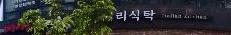


   

## 4. Appendix
    - How to Merge?
      1. SIFT+KNN-Matching Score(K=2)
          - low performance
          - slow
      
            ==============
            <vit384+sift> : vit 혼자가 best! / sift를 super point or LoFTR로 보완

            thres=1.6/1.8
            macro_mAP@1 : 0.5521513331019091
            micro_mAP@1 : 0.5269886363636364

            thres=1
            macro_mAP@1 : 0.8915119388057532
            micro_mAP@1 : 0.90625

                - total_time 314.73141279409174
                - query_time 3.244652777640197


            <vit384>

            thres = 1
            macro_mAP@1 : 0.8915119388057532
            micro_mAP@1 : 0.90625

                - total_time 158.26039798604324
                - query_time 1.631550233742731


            <sift>

            thres=1
            macro_mAP@1 : 0.49589365893186393
            micro_mAP@1 : 0.4943019943019943

                - total_time 155.82311609690078
                - query_time 1.6064234851648282
            =================
        
        2. Cosine_Similarity Matching Score
            - mAP/ Recall/ Precision

            ========
            <vit384>

            match_thres = 1/4
            macro_mAP@1 : 0.8989443689185956
            micro_mAP@1 : 0.9161931818181818
            recall@1:0.78125
            precision@1:0.7890961262553802
                
                - total_time 0.07479447196237743
                - query_time 0.000770510989241302
            
            
            <sift_vlad + vit384>

            match_thres = 1/4
            macro_mAP@1 : 0.8048404773920238
            micro_mAP@1 : 0.8238636363636364
            recall@1:0.6633522727272727
            precision@1:0.7262830482115086
            
                - total_time 0.10111607192084193
                - query_time 0.001042093515165688

            
            <sift_vlad>
            
            match_thres = 1/4
            
            macro_mAP@1 : 0.5584251961905086
            micro_mAP@1 : 0.5359195402298851
            recall@1:0.3793103448275862
            precision@1:0.499054820415879
            
                - total_time 0.07401395798660815
                - query_time 0.0007626650202059254
            =========
            
            - Result_Dictionary
            
            ========
            {'870': {'0_16_False': [],
              '1_5_False': ['6_5_False'],
              '2_16_False': ['2_16_False'],
              '3_100_False': [],
              '4_100_False': [],
              '5_100_False': [],
              '6_6_False': ['9_6_False'],
              '7_10_False': [],
              '8_9_False': [],
              '9_7_False': ['13_7_False'],
              '10_15_False': ['22_15_False'],
              '11_12_False': ['10_12_False'],
              '12_11_False': ['18_11_False'],
              '13_4_False': ['19_4_False'],
              '14_8_False': ['20_8_False'],
              '15_2_False': ['24_2_False'],
              '16_13_False': ['25_13_False'],